In [19]:
import warnings
warnings.simplefilter('always')

import warnings
warnings.filterwarnings("ignore")

In [21]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation

import GPy
from GPy.models.gp_regression import GPRegression
from emukit.multi_fidelity.kernels.linear_multi_fidelity_kernel import LinearMultiFidelityKernel
from emukit.multi_fidelity.convert_lists_to_array import convert_xy_lists_to_arrays
from emukit.model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models.linear_model import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array
from emukit.core.loop.user_function import MultiSourceFunctionWrapper
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel
from emukit.core import ParameterSpace, ContinuousParameter, InformationSourceParameter
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization.multi_source_acquisition_optimizer import MultiSourceAcquisitionOptimizer
from emukit.core.optimization import GradientAcquisitionOptimizer
from scipy.integrate import solve_ivp

import mf2

In [23]:
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": "Computer Modern",
})
FIG_SIZE = (12, 8)

In [136]:
class multifidelityGPR:
    def __init__(self, lf, hf, ndim=1):
        self.LF = lf
        self.HF = hf
        self.multifidelity = MultiSourceFunctionWrapper([lf, hf])
        self.iterates = []
        self.GP_iterates = []
        self.fidelity_list = []
        self.ndim = ndim

    def set_initial_data(self, n1, n2, bounds):
        np.random.seed(12346)
        x_low = np.random.rand(n1,self.ndim)
        x_high = x_low[:n2, :]
        y_low = self.multifidelity.f[0](x_low)
        y_high = self.multifidelity.f[1](x_high)
        self.x_array, self.y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])
        self.n_init = n1+n2
        self.n1 = n1
        self.n2 = n2
        
        if self.ndim==1:
            # Bounds
            lb, ub = bounds
            self.bounds = bounds
            x_plot = np.linspace(lb, ub, 500)[:, None]
            
        if self.ndim==2:
            self.bounds = bounds
            x1_range = np.linspace(0, 1, 200)
            x2_range = np.linspace(0, 1, 200)
            # Create mesh grid from x1 and x2 ranges
            X1, X2 = np.meshgrid(x1_range, x2_range)
            x_plot = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
            self.X1, self.X2 = X1, X2

        self.x_plot = x_plot
        self.x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
        self.x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)

    def true_min(self):
        y = self.multifidelity.f[1](self.x_plot)
        min = np.min(y)
        loc = self.x_plot[np.argmin(y)]
        return min, loc

    

    def set_model(self, x_array=None, y_array=None, ker='rbf'):
        if x_array==None:
            x_array = self.x_array
        if y_array==None:
            y_array = self.y_array
        
        n_fidelities = 2
        if self.ndim==1:
            lb, ub = self.bounds
            self.parameter_space = ParameterSpace([ContinuousParameter('x', lb, ub), InformationSourceParameter(n_fidelities)])
        else:
            paramspace = []
            for i in range(self.ndim):
                lb, ub = self.bounds[i]
                paramspace.append(ContinuousParameter('x'+str(i+1), 0, 1))
            paramspace.append(InformationSourceParameter(n_fidelities))
            self.parameter_space = ParameterSpace(paramspace)


        if ker=='rbf':
            kern_low = GPy.kern.RBF(self.ndim)
            kern_low.lengthscale.constrain_bounded(0.01, 0.5)
            
            kern_err = GPy.kern.RBF(self.ndim)
            kern_err.lengthscale.constrain_bounded(0.01, 0.5)

        else:
            kern_low = GPy.kern.Matern52(self.ndim)
            kern_low.lengthscale.constrain_bounded(0.01, 0.5)
            
            kern_err = GPy.kern.Matern52(self.ndim)
            kern_err.lengthscale.constrain_bounded(0.01, 0.5)
        
        
        multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
        gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)
        
        gpy_model.likelihood.Gaussian_noise.fix(0.1)
        gpy_model.likelihood.Gaussian_noise_1.fix(0)
        
        self.model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
        self.model.optimize()

    def set_acquisition(self, beta, cost_param):
        self.acquisition = CustomMultiFidelityAcquisition(self.model, 
                                                          self.parameter_space, 
                                                          cost_ratio=cost_param, 
                                                          ei_beta = beta, 
                                                          n_init=self.n_init)
    def init_bayes_loop(self):
        initial_loop_state = create_loop_state(self.x_array, self.y_array)
        acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(self.parameter_space), self.parameter_space)
        candidate_point_calculator = SequentialPointCalculator(self.acquisition, acquisition_optimizer)
        model_updater = FixedIntervalUpdater(self.model)
        self.loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

    def run_bayes_loop(self, n_iter, conv_plot=False):
        self.loop.run_loop(self.multifidelity, n_iter)
        sol = np.min(self.loop.loop_state.Y[self.loop.loop_state.X[:, -1] == 1])
        hf = self.loop.loop_state.X[self.loop.loop_state.X[:, -1] == 1][:, :-1]
        loc = hf[np.argmin(self.loop.loop_state.Y[self.loop.loop_state.X[:, -1] == 1])]

        best_so_far = np.min(self.model.Y[self.model.X[:, -1] == 1])
        hf = self.model.X[self.model.X[:, -1] == 1][:, :-1]
        best_loc = hf[np.argmin(self.model.Y[self.model.X[:, -1] == 1])]
        mean, var = self.model.predict(self.x_plot_high)
        best_mean = np.min(mean)
        best_mean_loc = self.x_plot_high[np.argmin(mean), :-1]
        iterate = np.hstack([best_loc, best_so_far])
        GP_iterate = np.hstack([best_mean_loc, best_mean])

        y_last = self.multifidelity.f[1](best_mean_loc)
        
        if y_last[0] < best_so_far:
            best_so_far = y_last[0]
            best_loc = best_mean_loc

        iterate = np.hstack([best_loc, best_so_far])
        self.iterates.append(iterate)
        self.fidelity_list.append(1)
        self.GP_iterates.append(self.GP_iterates[-1])
        
        self.GP_iterates = np.array(self.GP_iterates)
        self.iterates = np.array(self.iterates)

        if conv_plot:
            self.plot_results()

        return loc, sol

    def set_loop_events(self, events):
        for event in events:
            self.loop.iteration_end_event.append(event)

    def loop_plots(self, optimization=False, acquisition=False):
        if optimization:
            self.loop.iteration_end_event.append(self.plot_optimization)
        if acquisition:
            self.loop.iteration_end_event.append(self.plot_acquisition)
    
    def loop_plots2D(self, optimization=False, acquisition=False):
        if optimization:
            self.loop.iteration_end_event.append(self.plot_optimization2D)
        if acquisition:
            self.loop.iteration_end_event.append(self.plot_acquisition2D)
        

    def best_solution(self, loop, loop_state):
        xnew = self.loop.loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        self.fidelity_list.append(fidelity_idx)
        best_so_far = np.min(self.loop.loop_state.Y[self.loop.loop_state.X[:, -1] == 1])
        hf = self.loop.loop_state.X[self.loop.loop_state.X[:, -1] == 1][:, :-1]
        best_loc = hf[np.argmin(self.loop.loop_state.Y[self.loop.loop_state.X[:, -1] == 1])]
        mean, var = loop.model_updaters[0].model.predict(self.x_plot_high)
        best_mean = np.min(mean)
        best_mean_loc = self.x_plot_high[np.argmin(mean), :-1]
        iterate = np.hstack([best_loc, best_so_far])
        GP_iterate = np.hstack([best_mean_loc, best_mean])
        self.iterates.append(iterate)
        self.GP_iterates.append(GP_iterate)


    def true_model(self):
        self.true_model = self.multifidelity.f[1](self.x_plot)
        self.min = np.min(self.true_model)
        self.loc = self.x_plot[np.argmin(self.true_model)]
        #if self.negate:
        #    self.true_model = -self.true_model
        #    self.max = -self.max

    def plot_acquisition(self, loop, loop_state):
        plt.figure(figsize=(5,3))
        colours = ['b', 'r']
        plt.plot(self.x_plot_low[:, 0], self.loop.candidate_point_calculator.acquisition.evaluate(self.x_plot_low), 'b')
        plt.plot(self.x_plot_high[:, 0], self.loop.candidate_point_calculator.acquisition.evaluate(self.x_plot_high), 'r')
        
        previous_x_collected = self.loop.loop_state.X[[-1], :]
        fidelity_idx = int(previous_x_collected[0, -1])
        plt.scatter(previous_x_collected[0, 0], 
                    self.loop.candidate_point_calculator.acquisition.evaluate(previous_x_collected), 
                    color=colours[fidelity_idx])
        plt.legend(['Low fidelity', 'High fidelity'], fontsize=12)
        plt.title('Acquisition Function at Iteration ' + str(self.loop.loop_state.iteration))
        plt.xlabel('x')
        plt.xlim(0, 1)
        plt.ylabel('Acquisition Value')
        plt.tight_layout()
        plt.show()
    
    def plot_optimization(self, loop, loop_state):
        plt.figure(figsize=(5,3))
        colours = ['b', 'r']
        is_high_fidelity = self.loop.loop_state.X[:, -1] == 1
        x_low=self.loop.loop_state.X[~is_high_fidelity, :-1]
        y_low=self.loop.loop_state.Y[~is_high_fidelity]
        x_high=self.loop.loop_state.X[is_high_fidelity, :-1]
        y_high=self.loop.loop_state.Y[is_high_fidelity]
    
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
    
        #plt.figure(figsize=FIG_SIZE)
        self.plot_with_error_bars(self.x_plot_high[:, :-1], mean_low, var_low, 'b')
        self.plot_with_error_bars(self.x_plot_high[:, :-1], mean_high, var_high, 'r')
        plt.plot(self.x_plot, self.true_model, 'k--')
        plt.scatter(x_low, y_low, color='b')
        plt.scatter(x_high, y_high, color='r')
    
        xnew = self.loop.loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,0])
        plt.scatter(xnew[0, 0], 
                    ynew, 
                    color=colours[fidelity_idx], marker='*', s=420)
        
        plt.vlines(xnew[0,0], -15, ynew, linestyle='-.', linewidth=5, color=colours[fidelity_idx])
        
        plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
        plt.title('Multifidelity Bayesian Optimization; Iteration {}'.format(self.loop.loop_state.iteration))
        plt.xlim(0, 1)
        plt.ylim(-15,25)
        plt.xlabel('x')
        plt.ylabel('y');
        plt.show()

    def plot_acquisition2D(self, loop, loop_state):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        colours = ['b', 'r']
        acq_low = self.loop.candidate_point_calculator.acquisition.evaluate(self.x_plot_low)
        acq_high = self.loop.candidate_point_calculator.acquisition.evaluate(self.x_plot_high)
        c1 = axes[0].contourf(self.X1, self.X2, acq_high.reshape(self.X1.shape), levels=50, cmap='viridis')
        c2 = axes[1].contourf(self.X1, self.X2, acq_high.reshape(self.X1.shape), levels=50, cmap='viridis')
        
        cbar1 = fig.colorbar(c1, ax=axes[0], orientation='vertical', fraction=0.05, pad=0.1)
        cbar1.set_label('Low-fidelity Acquisition function')

        cbar2 = fig.colorbar(c2, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.1)
        cbar2.set_label('Multi-fidelity Acquisition function')
        
        xnew = loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        axes[fidelity_idx].scatter(xnew[:, 0], 
                    xnew[:, 1], 
                    color=colours[fidelity_idx], marker='*', s=220, label='next location')
        axes[fidelity_idx].legend()
        plt.suptitle('Acquisition Function at Iteration ' + str(self.loop.loop_state.iteration))
        axes[0].set_title('Low-fidelity')
        axes[0].set_xlabel('x1')
        axes[0].set_xlim(0, 1)
        axes[0].set_ylabel('x2')
        axes[1].set_title('Multi-fidelity')
        axes[1].set_xlabel('x1')
        axes[1].set_xlim(0, 1)
        plt.tight_layout()
        plt.show()

    def plot_optimization2D(self, loop, loop_state):
        colours = ['b', 'r']
        is_high_fidelity = loop.loop_state.X[:, -1] == 1
        x_low=loop.loop_state.X[~is_high_fidelity, :-1]
        y_low=loop.loop_state.Y[~is_high_fidelity]
        x_high=loop.loop_state.X[is_high_fidelity, :-1]
        y_high=loop.loop_state.Y[is_high_fidelity]
    
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
    
        plt.figure(figsize=(8,6))
        plt.contourf(self.X1, self.X2, mean_high.reshape(self.X1.shape), levels=50, cmap='viridis')
        plt.colorbar(label="Multifidelity GP Mean")
        plt.scatter(x_low[:, 0], x_low[:, 1], color='b', label='Low fidelity points')
        plt.scatter(x_high[:, 0], x_high[:, 1], color='r', label='High fidelity points')
    
        xnew = loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,:-1])
        plt.scatter(xnew[:, 0], 
                    xnew[:, 1], 
                    color=colours[fidelity_idx], marker='*', s=220, label='next location')
        plt.legend()
        plt.title('Multifidelity Bayesian Optimization; Iteration {}'.format(self.loop.loop_state.iteration))
        plt.xlabel('x1')
        plt.ylabel('x2');
        plt.show()

    def plot_with_error_bars(self, x, mean, var, color):
            plt.plot(x, mean, color=color)
            plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                            alpha=0.2, color=color)

    def plot_model(self, figsize):
        plt.figure(figsize=figsize)
        x_low = self.x_array[self.x_array[:, 1] == 0][:, 0]
        x_high = self.x_array[self.x_array[:, 1] == 1][:, 0]
        y_low = self.y_array[self.x_array[:, 1] == 0]
        y_high = self.y_array[self.x_array[:, 1] == 1]
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
        
        #plt.figure(figsize=FIG_SIZE)
        self.plot_with_error_bars(self.x_plot_high[:, 0], mean_low, var_low, 'b')
        self.plot_with_error_bars(self.x_plot_high[:, 0], mean_high, var_high, 'r')
        plt.plot(self.x_plot, self.true_model, 'k--')
        plt.scatter(x_low, y_low, color='b')
        plt.scatter(x_high, y_high, color='r')
        plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
        plt.title('Low and High Fidelity Models')
        lb, ub = self.bounds
        plt.xlim(lb, ub)
        plt.xlabel('x')
        plt.ylabel('y');
        plt.show()

    def plot_results(self):
        colours = ['b', 'r']
        min, loc = self.min, self.loc
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(np.arange(1, self.loop.loop_state.iteration+2, 1), self.iterates[:,-1], label='Best solution', zorder=3)
        axes[0].plot(np.arange(1, self.loop.loop_state.iteration+2, 1), self.GP_iterates[:,-1], label='Best GP mean', zorder=4)
        for i in range(len(self.GP_iterates[:,-1])):
            axes[0].scatter(i+1, self.GP_iterates[:,-1][i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
            axes[0].scatter(i+1, self.iterates[:,-1][i], color = colours[self.fidelity_list[i]], zorder=2, s=50)
        axes[0].set_xlim(1, self.loop.loop_state.iteration+1)
        axes[0].hlines(min, 0, self.loop.loop_state.iteration+1, 'k', linestyle='--', label='True Optimum')
        axes[0].legend()
        axes[0].set_xlabel('Iterations')
        axes[0].set_ylabel(r'$\hat{f}$')

        if self.ndim==1:
            axes[1].plot(np.arange(1, self.loop.loop_state.iteration+2, 1), self.iterates[:,0], label='Best location', zorder=2)
            axes[1].plot(np.arange(1, self.loop.loop_state.iteration+2, 1), self.GP_iterates[:,0], label='Best GP location', zorder=2)
            axes[1].set_xlim(1, self.loop.loop_state.iteration+1)
            for i in range(len(self.GP_iterates[:,-1])):
                axes[1].scatter(i+1, self.GP_iterates[:,0][i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
                axes[1].scatter(i+1, self.iterates[:,0][i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
            axes[1].hlines(loc, 0, self.loop.loop_state.iteration+1, 'k', linestyle='--', label='True location')
            axes[1].legend()
            axes[1].set_xlabel('Iterations')
            axes[1].set_ylabel(r'$\hat{x}$')
        else:
            norm_iterates = [np.linalg.norm(i - loc) for i in self.iterates[:,:-1]]
            norm_GP_iterates = [np.linalg.norm(i - loc) for i in self.GP_iterates[:,:-1]]
            axes[1].plot(np.arange(1, self.loop.loop_state.iteration+2, 1), norm_iterates, label='Best location', zorder=2)
            axes[1].plot(np.arange(1, self.loop.loop_state.iteration+2, 1), norm_GP_iterates, label='Best GP location', zorder=2)
            for i in range(len(self.GP_iterates[:,-1])):
                axes[1].scatter(i+1, norm_iterates[i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
                axes[1].scatter(i+1, norm_GP_iterates[i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
            axes[1].set_xlim(1, self.loop.loop_state.iteration+1)
            axes[1].legend()
            axes[1].set_xlabel('Iterations')
            axes[1].set_ylabel(r'$|\hat{x} - x_*|$')
            
    def save_animation_data(self, loop, loop_state):
        is_high_fidelity = self.loop.loop_state.X[:, -1] == 1
        x_low = self.loop.loop_state.X[~is_high_fidelity, 0]
        y_low = self.loop.loop_state.Y[~is_high_fidelity]
        x_high =self.loop.loop_state.X[is_high_fidelity, 0]
        y_high = self.loop.loop_state.Y[is_high_fidelity]
    
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
    
        xnew = self.loop.loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,0])
        
        GP_mean_h_list.append(mean_high)
        GP_mean_l_list.append(mean_low)
        GP_variance_h_list.append(var_high)
        GP_variance_l_list.append(var_low)
        Xlist.append(loop.loop_state.X)
        xnew_list.append(xnew)
        ylist.append(loop.loop_state.Y)
        ynew_list.append(ynew)

    # Animation Function
    def animate(self, i):  
        """This function will be called by the animation function iteratively to plot"""
        self.fig.clear()
        colours = ['b', 'r']
        is_high_fidelity = Xlist[i][:, -1] == 1
        x_low=Xlist[i][~is_high_fidelity, 0]
        y_low=ylist[i][~is_high_fidelity]
        x_high=Xlist[i][is_high_fidelity, 0]
        y_high=ylist[i][is_high_fidelity]
    
        mean_low, var_low = GP_mean_l_list[i], GP_variance_l_list[i]
        mean_high, var_high = GP_mean_h_list[i], GP_variance_h_list[i]
        
        plt.plot(self.x_plot_high[:, 0], mean_low, color='b')
        plt.fill_between(self.x_plot_high[:, 0].flatten(),
                         mean_low.flatten() - 1.96*var_low.flatten(),
                         mean_low.flatten() + 1.96*var_low.flatten(), alpha=0.2, color='b')
    
        plt.plot(self.x_plot_high[:, 0], mean_high, color='r')
        plt.fill_between(self.x_plot_high[:, 0].flatten(),
                         mean_high.flatten() - 1.96*var_high.flatten(),
                         mean_high.flatten() + 1.96*var_high.flatten(), alpha=0.2, color='r')
        
        plt.plot(self.x_plot, self.multifidelity.f[1](self.x_plot), 'k--')
        plt.plot(self.x_plot, self.multifidelity.f[0](self.x_plot), 'g--')
        plt.scatter(x_low, y_low, color='b')
        plt.scatter(x_high, y_high, color='r')
    
        xnew = xnew_list[i]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,0])
        plt.scatter(xnew[0, 0], 
                    ynew, 
                    color=colours[fidelity_idx], marker='*', s=420)
        
        plt.vlines(xnew[0,0], -15, ynew, linestyle='-.', linewidth=5, color=colours[fidelity_idx])
        
        plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity', 'True low fidelity'])
        plt.xlim(0, 1)
        plt.ylim(-15,25)
        plt.xlabel('x')
        plt.ylabel('y');    
        print(i)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.title(r'MFGPR Iteration {}'.format(i+1), fontsize=35)
        
    def save_anim(self, name):
        self.fig = plt.figure(figsize=FIG_SIZE)
        ani = animation.FuncAnimation(self.fig, self.animate, frames=(len(xnew_list))) #animation function. frames will iterate i in animate
        ani.save(name+'.gif', writer='pillow', fps=1) #save animation

In [138]:
# Define custom acquisition model
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel
import numpy as np
from scipy.stats import norm


class CustomMultiFidelityAcquisition(Acquisition):
    def __init__(self, model: IModel, space, n_init, ei_beta=15, cost_ratio=1/5):
        """
        Custom acquisition function for multi-fidelity optimization.

        :param model: Multi-fidelity model (e.g., a multi-fidelity GP)
        :param space: Search space over which the optimization is performed
        :param cost_function: Optional cost function that assigns a cost to each fidelity level
        """
        super().__init__()
        self.model = model  # Multi-fidelity GP model
        self.space = space  # The parameter space (search space)
        self.cost_ratio = cost_ratio  # Optional cost ratio
        self.ei_beta = ei_beta
        self.n_init = n_init
    
    @property
    def has_gradients(self):
        # If gradients are implemented, return True. Otherwise, return False.
        return False

    def evaluate(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function at the given points.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Acquisition values (np.ndarray of shape (n_points,))
        """
        # Multi-fidelity model's prediction (mean, variance) at point x
        mean, variance = self.model.predict(x)

        if x[0][-1] == 0:
            best_so_far = np.min(self.model.Y[self.model.X[:, -1] == 0])
        if x[0][-1] == 1:
            best_so_far = np.min(self.model.Y[self.model.X[:, -1] == 1])

        if self.cost_ratio==None:
            acquisition_value = self._expected_improvement(mean, variance, best_so_far)
        else:
            # This can be modified to include more sophisticated information-based criteria
            acquisition_value = self._expected_improvement(mean, variance, best_so_far) - self._cost_function(x)
        return acquisition_value

    def _expected_improvement(self, mean, variance, best_so_far):
        """
        Custom Expected Improvement calculation.

        :param mean: Predicted mean from the GP model
        :param variance: Predicted variance from the GP model
        :return: Expected Improvement (np.ndarray)
        """
        improvement = best_so_far - mean
        z = improvement / np.sqrt(variance)
        ei = improvement * norm.cdf(z) + self.ei_beta*(np.sqrt(variance) * norm.pdf(z))
        ei[ei == 0] = np.zeros(ei[ei == 0].shape)   
        return ei

    def _cost_function(self, x):
        b = self.cost_ratio
        n1 = sum(self.model.X[:, -1] == 0) # LF points
        n2 = sum(self.model.X[:, -1] == 1) # HF points
        
        if x[0][-1] == 0:
            cost = b*(n1+ 1) + n2
        if x[0][-1] == 1:
            cost = b*n1 + (n2+1)
        return cost/(1 + len(self.model.X) - self.n_init)
    
    def evaluate_with_gradients(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function and return gradients.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Tuple of (acquisition values, gradients)
        """
        raise NotImplementedError("Gradients are not implemented for this acquisition function.")

In [140]:
def low_fidelity_toy(x):
    #return (0.5*((x*6-2)**2)*np.sin((x*6-2)*2)) + 10*(x-0.5) - 5
    return 0.5*high_fidelity_toy(x) + 10*(x-0.5) -5

def high_fidelity_toy(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


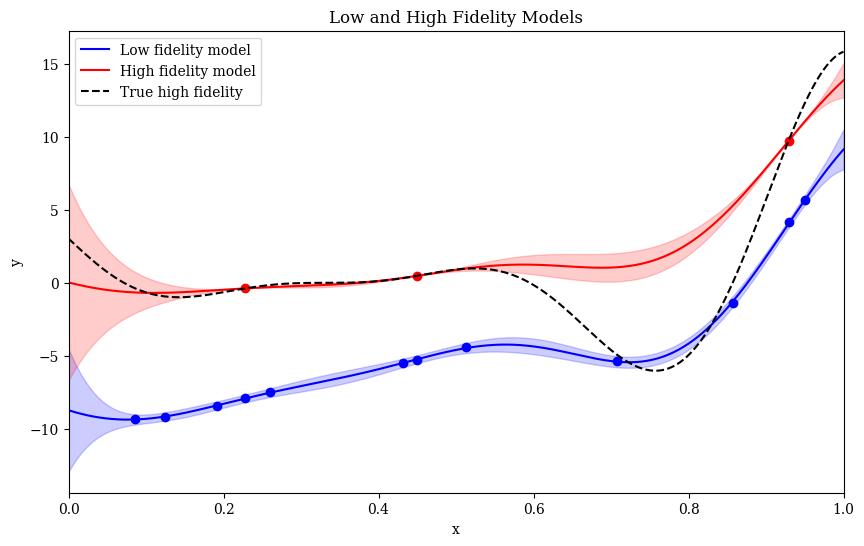

In [142]:
mfgp = multifidelityGPR(low_fidelity_toy, high_fidelity_toy, ndim=1)
n = np.array([12, 3])
mfgp.set_initial_data(12, 3, np.array([0, 1]))
mfgp.set_model()
mfgp.true_model()
mfgp.plot_model(figsize=(10,6))
mfgp.set_acquisition(5, 1)
mfgp.init_bayes_loop()
mfgp.loop_plots(optimization=True, acquisition=True)

In [144]:
# Loop events
GP_mean_h_list =[]
GP_mean_l_list=[]
GP_variance_h_list=[]
GP_variance_l_list=[]
Xlist = []
xnew_list=[]
ylist = []
ynew_list=[]
    
mfgp.set_loop_events([mfgp.best_solution, mfgp.save_animation_data])

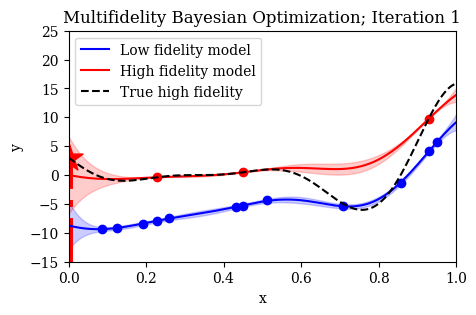

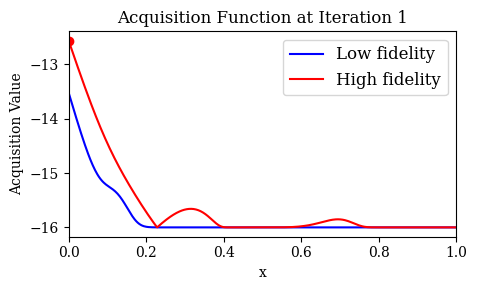

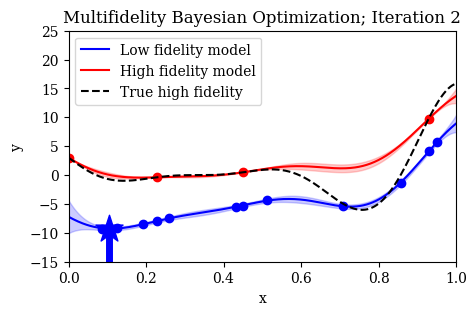

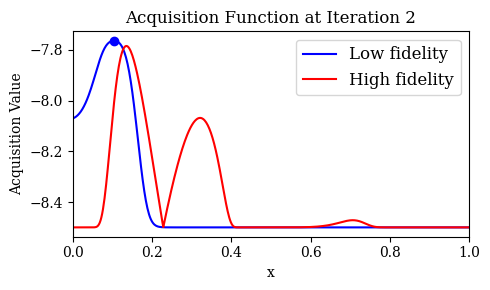

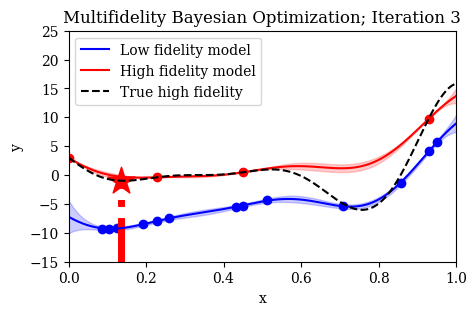

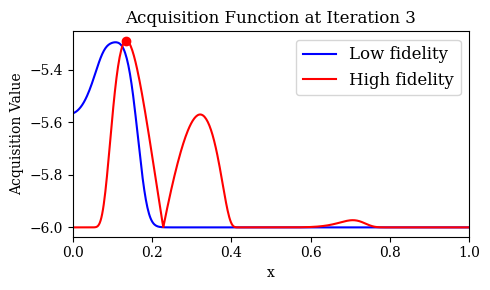

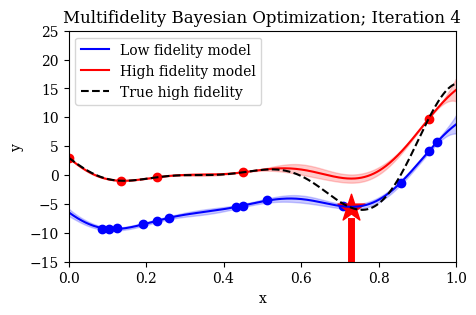

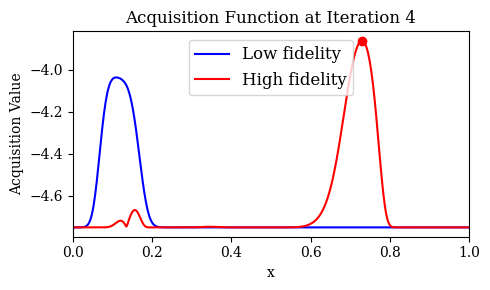

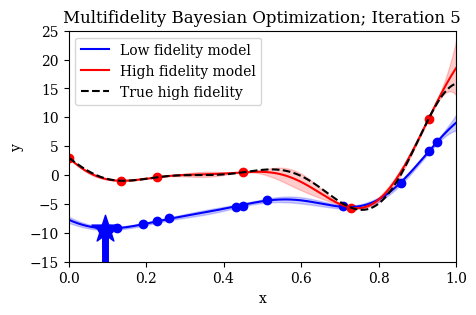

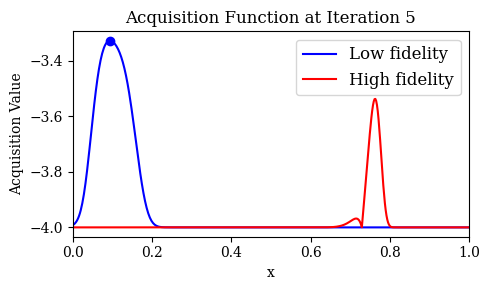

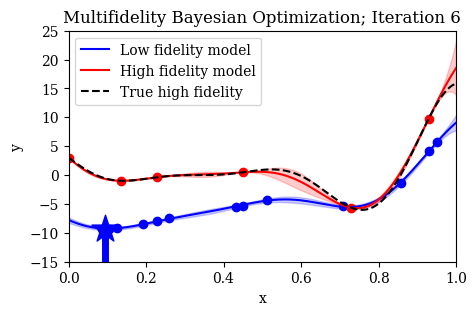

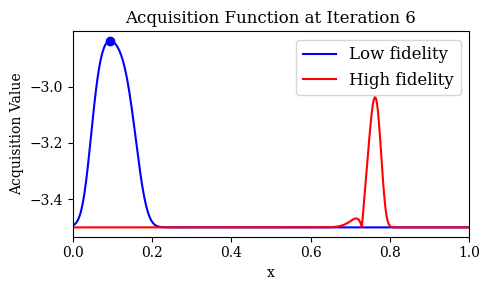

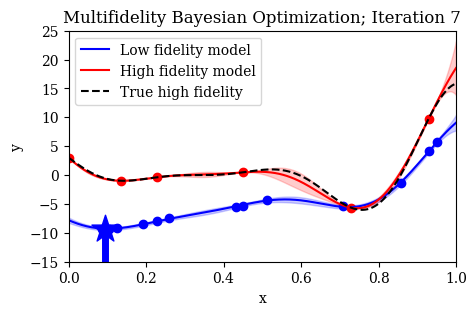

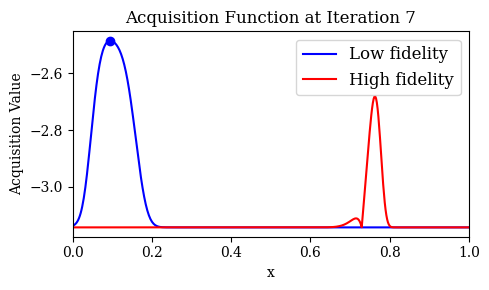

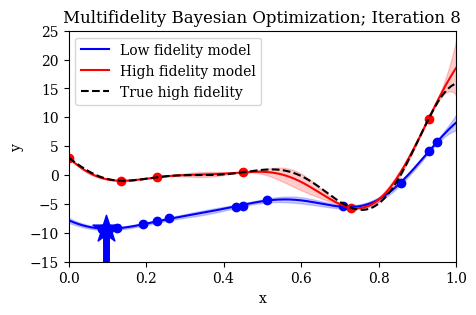

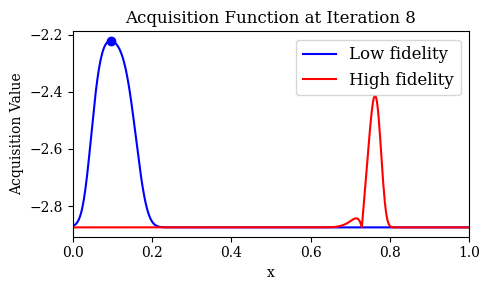

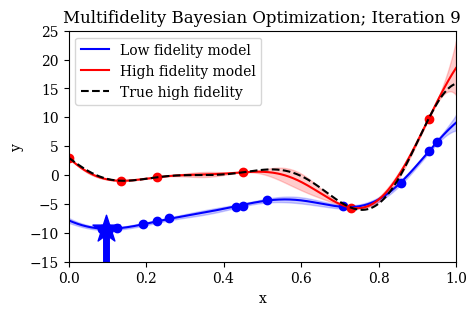

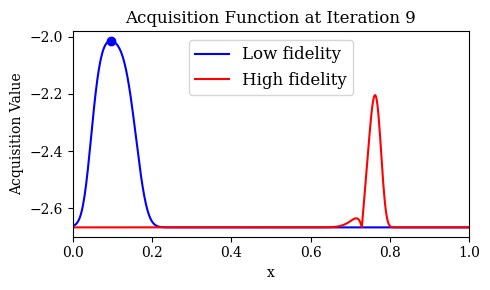

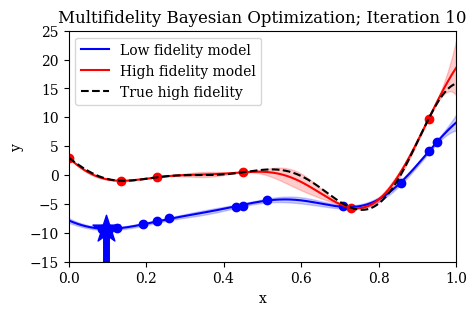

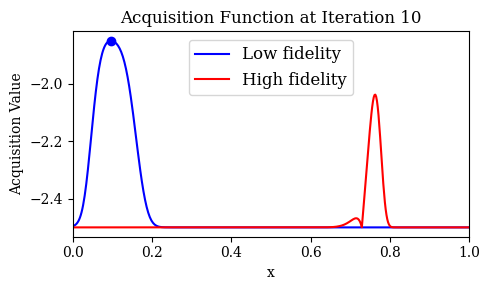

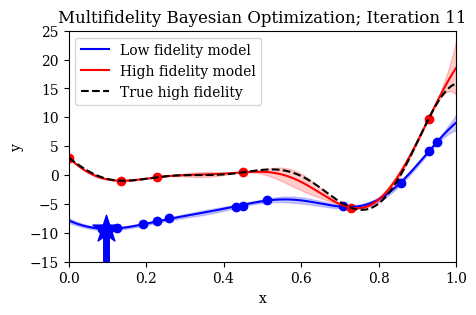

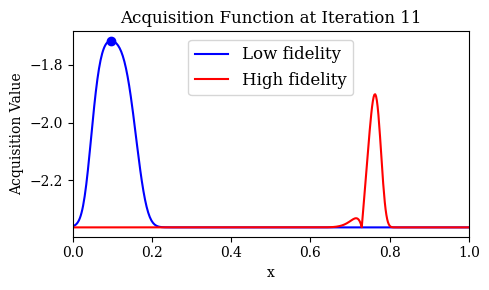

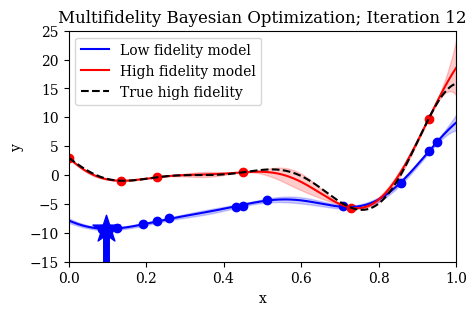

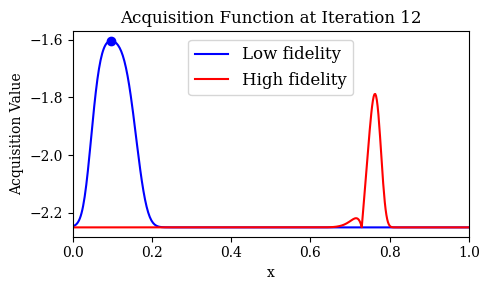

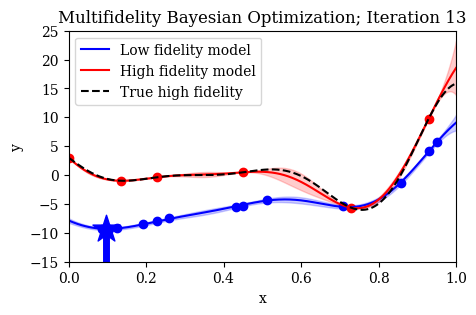

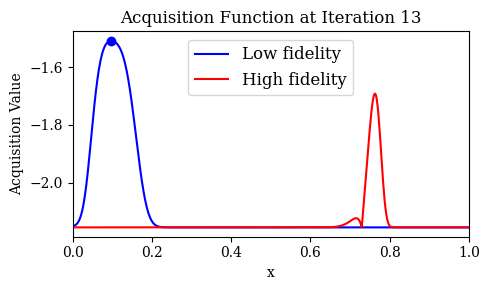

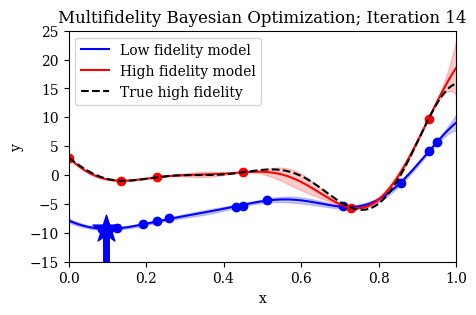

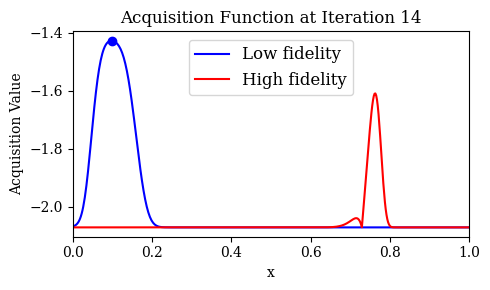

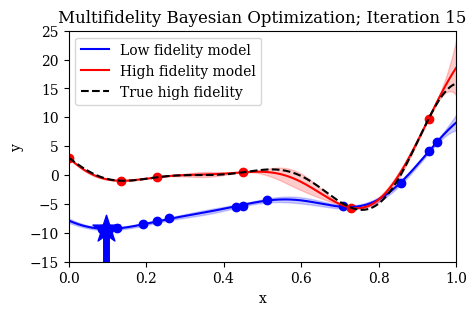

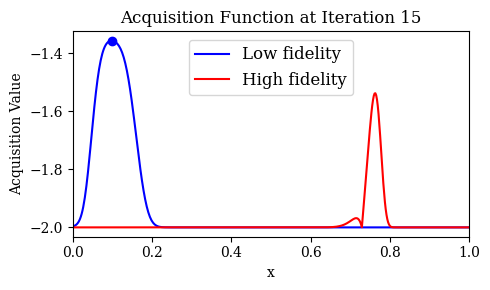

(array([0.7295547]), -5.646641762353399)

In [146]:
mfgp.run_bayes_loop(15)

In [147]:
n1 = sum(mfgp.model.X[:, -1] == 0) # LF points
n2 = sum(mfgp.model.X[:, -1] == 1) # HF points

In [150]:
n1 - mfgp.n1

12

In [152]:
n2 - mfgp.n2

3

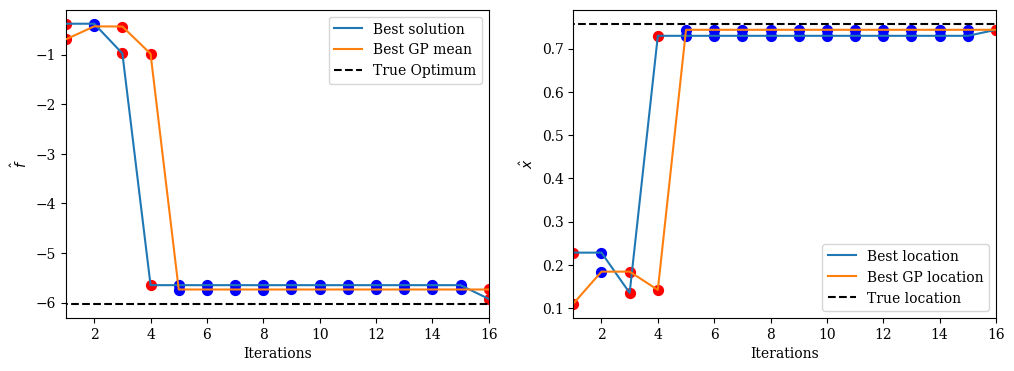

In [154]:
mfgp.plot_results()

0
0
1
2


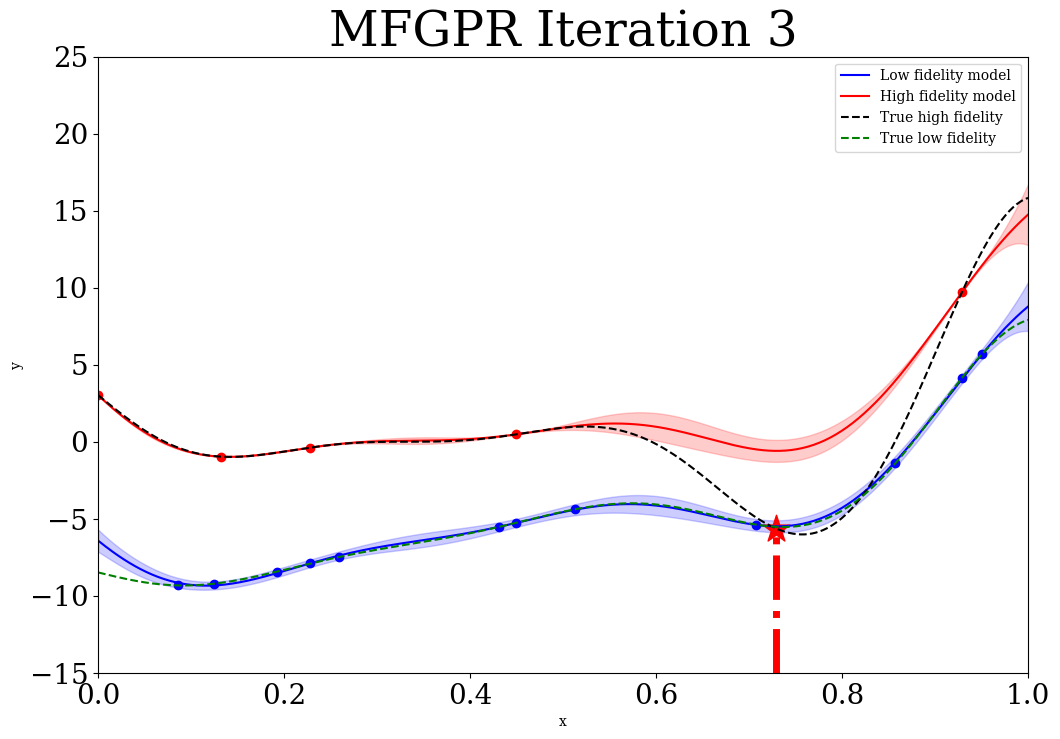

In [379]:
mfgp.save_anim('testcode')

In [190]:
def lf(x):
    return -mf2.bohachevsky.low(x).reshape(-1,1)

def hf(x):
    return -mf2.bohachevsky.high(x).reshape(-1,1)

mfgp = multifidelityGPR(lf, hf, ndim=2)
mfgp.set_initial_data(12, 2, np.array([[0, 1], [0, 1]]))
mfgp.set_model()
#mfgp.plot_model()
mfgp.true_model()
mfgp.set_acquisition(5, 10)
mfgp.init_bayes_loop()
mfgp.loop_plots2D(optimization=True, acquisition=True)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


In [192]:
mfgp.model.X

ObsAr([[0.92899722, 0.44916575, 0.        ],
       [0.22831532, 0.70714404, 0.        ],
       [0.19195997, 0.85719177, 0.        ],
       [0.51332158, 0.0857998 , 0.        ],
       [0.25959895, 0.431627  , 0.        ],
       [0.95031458, 0.12427324, 0.        ],
       [0.94177041, 0.03279479, 0.        ],
       [0.12023077, 0.79321705, 0.        ],
       [0.50022656, 0.08240088, 0.        ],
       [0.69241064, 0.08590672, 0.        ],
       [0.00291934, 0.16050773, 0.        ],
       [0.43634521, 0.65420707, 0.        ],
       [0.92899722, 0.44916575, 1.        ],
       [0.22831532, 0.70714404, 1.        ]])

In [194]:
mfgp.set_loop_events([mfgp.best_solution])

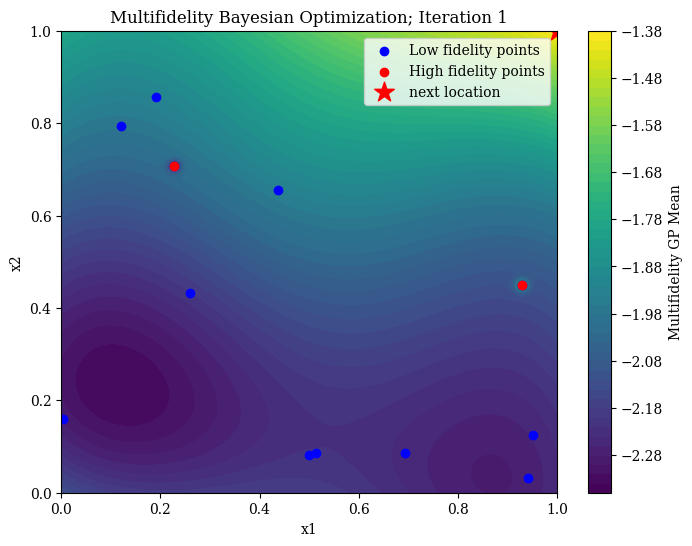

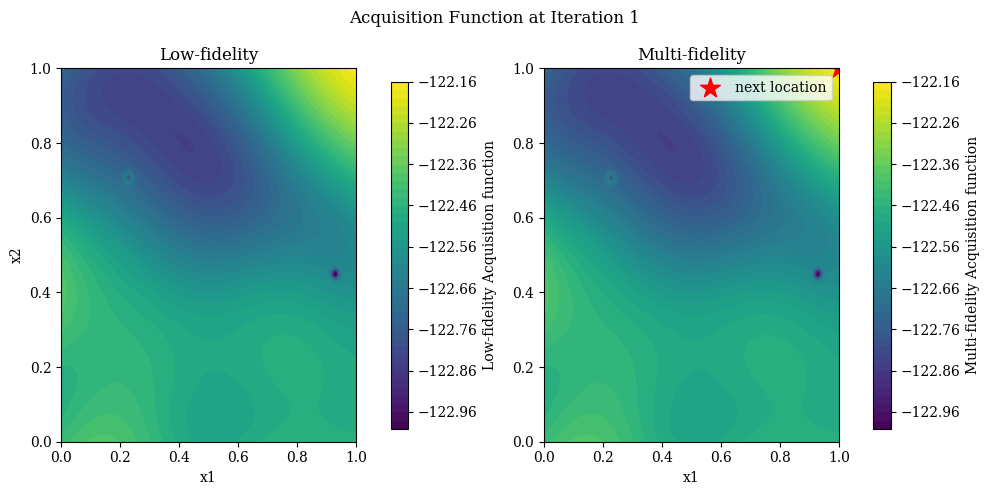

In [196]:
x, f = mfgp.run_bayes_loop(1)

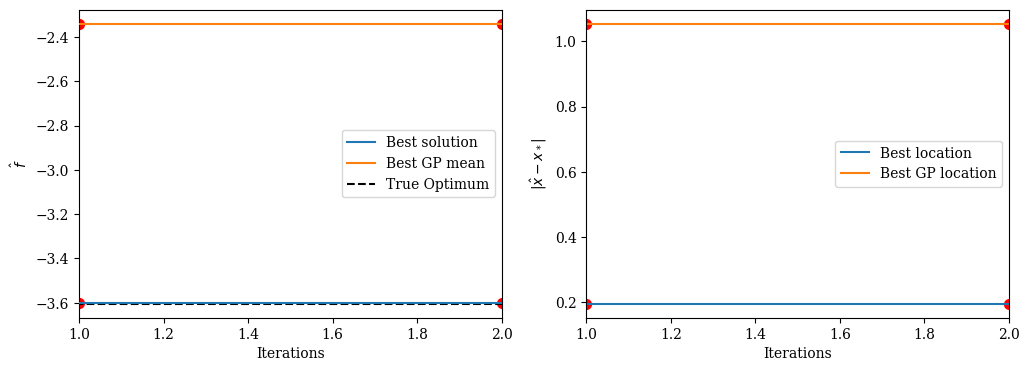

In [198]:
mfgp.plot_results()

In [33]:
n1 = sum(mfgp.model.X[:, -1] == 0) # LF points
n2 = sum(mfgp.model.X[:, -1] == 1) # HF points

In [34]:
n1 - mfgp.n1

18

In [35]:
n2 - mfgp.n2

7

In [870]:
x, f

(array([0., 1.]), 1.1804080208620997)

In [876]:
loc, min

(array([0., 1.]), 1.1804080208620997)

In [277]:
# Enzyme Toy Models
def toyModel(t,x, k):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    k1,k2,k3 = k
    dS0  = -k1*x[0]*x[3] + k2*x[1]
    dES0 =  k1*x[0]*x[3] - k2*x[1] - k3*x[1]
    dS1  =  k3*x[1] 
    dE   = -k1*x[3]*x[0] + k2*x[1] + k3*x[1] 
    return [dS0, dES0, dS1, dE]


def reducedToyModel(t,x, k):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    k1,k2,k3, E0 = k
    ke = (k1*k3)/(k2+ k3)
    dS0  = -ke*x[0]*E0
    dS1  = ke*x[0]*E0
    return [dS0, dS1]


def high_fidelity_toy(E):
    S0 = 5.0
    C0 = np.array([S0, 0.0, 0.0, E]) # initial concentrations of S0, ES0, ES1, S1, S2, E
    kvals = np.array([10, 50, 2])
    
    sol1 = solve_ivp(lambda t, x: toyModel(t, x, kvals), 
                         [0, 100], 
                         C0,
                         # t_eval=time_points, 
                         atol=np.sqrt(np.finfo(float).eps), 
                         rtol=np.sqrt(np.finfo(float).eps))
    return abs(10 - sol1.t[np.argmin(abs(sol1.y[2,:] - 0.67*S0))])


def low_fidelity_toy(E):
    S0 = 5.0
    C0 = np.array([S0, 0.0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
    kvals = np.array([10, 50, 2, E])
    sol2 = solve_ivp(lambda t, x: reducedToyModel(t, x, kvals), 
                         [0, 100], 
                         C0[:2],
                         # t_eval=time_points, 
                         atol=np.sqrt(np.finfo(float).eps), 
                         rtol=np.sqrt(np.finfo(float).eps))
    return abs(10 - sol2.t[np.argmin(abs(sol2.y[1,:] - 0.67*S0))])

def lf(x):
    if (type(x)) == np.ndarray:
        lf_vals = np.array([low_fidelity_toy(i) for i in x.ravel()]).reshape(-1,1)
    else:
        print(type(x))
        lf_vals = low_fidelity_toy(x)
    return lf_vals
def hf(x):
    if (type(x)) == np.ndarray:
        hf_vals = np.array([high_fidelity_toy(i) for i in x.ravel()]).reshape(-1,1)
    else:
        hf_vals = high_fidelity_toy(x)
    return hf_vals

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale


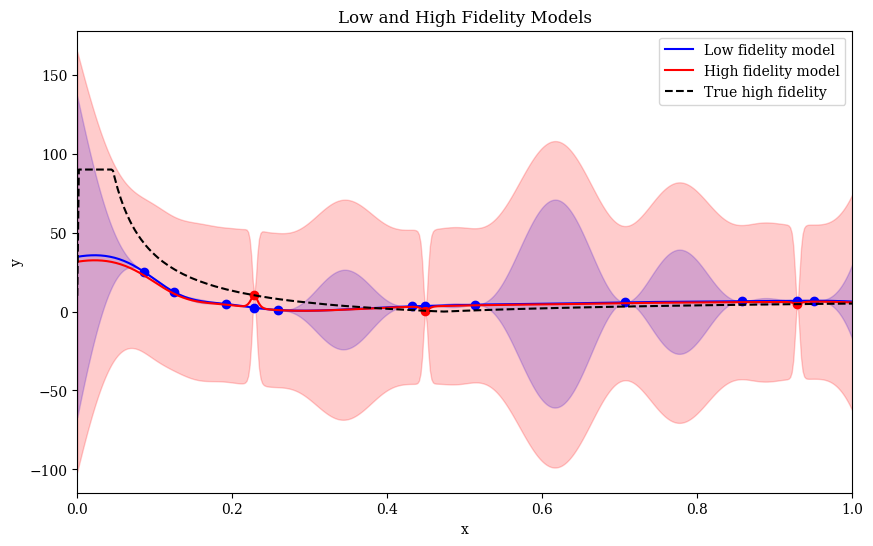

In [279]:
mfgp = multifidelityGPR(lf, hf, ndim=1)
n = np.array([12, 3])
mfgp.set_initial_data(12, 3, np.array([0, 1]))
mfgp.set_model(ker='mat')
mfgp.true_model()
mfgp.plot_model(figsize=(10,6))
mfgp.set_acquisition(15, 10)
mfgp.init_bayes_loop()
mfgp.loop_plots(optimization=True, acquisition=True)

In [280]:
mfgp.set_loop_events([mfgp.best_solution])

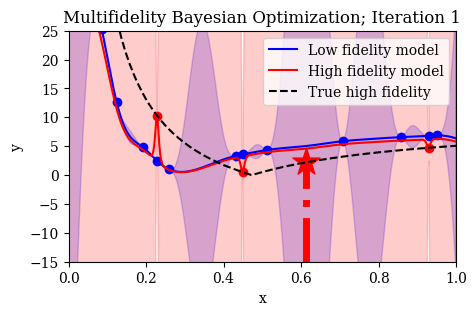

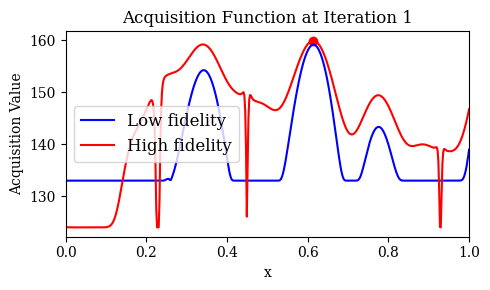

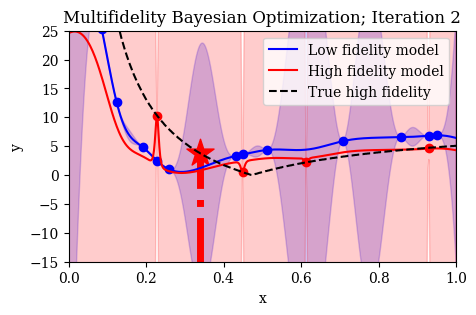

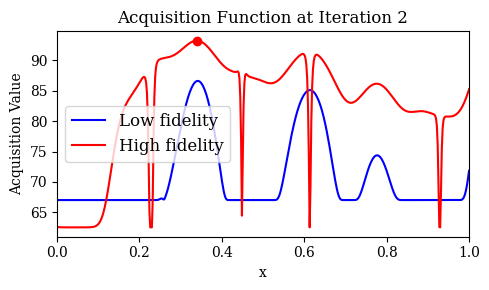

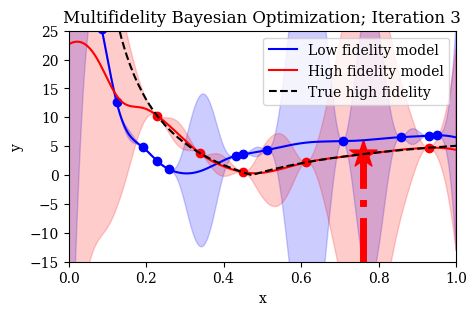

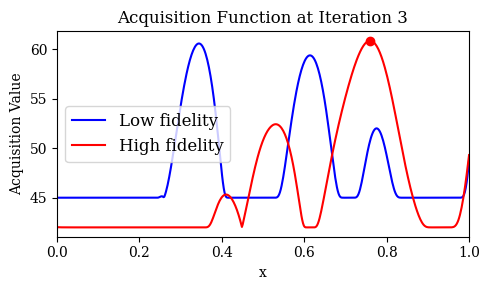

<class 'numpy.float64'>


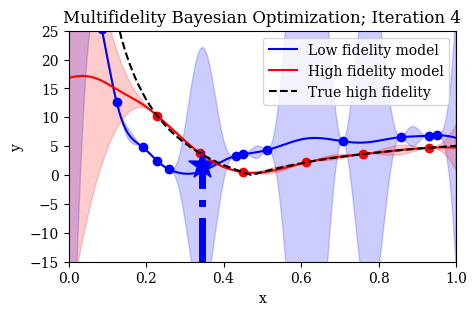

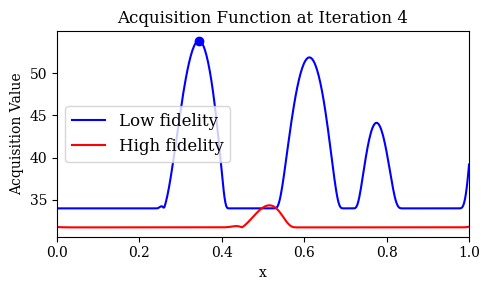

<class 'numpy.float64'>


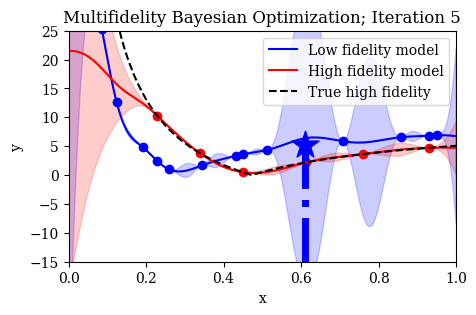

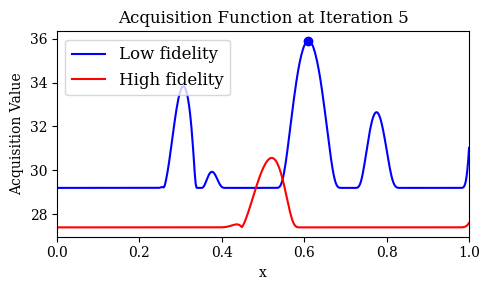

<class 'numpy.float64'>


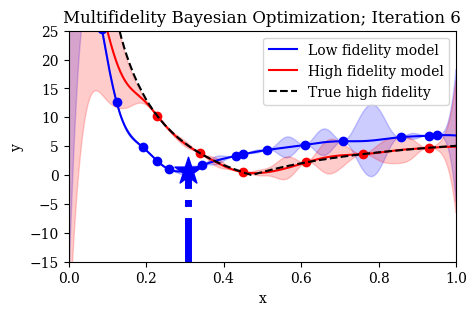

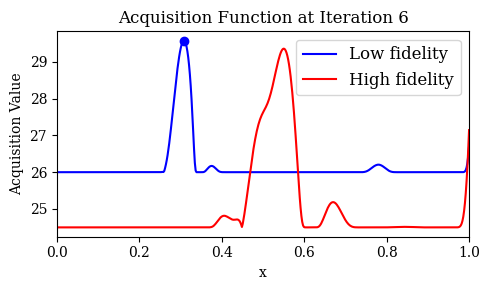

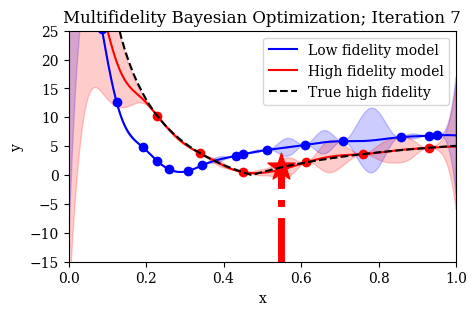

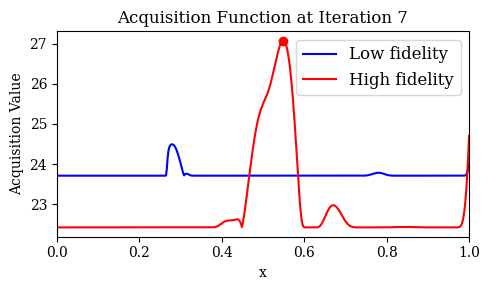

<class 'numpy.float64'>


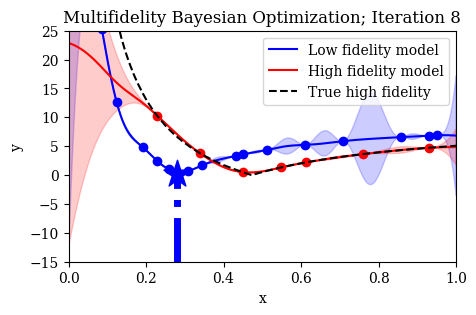

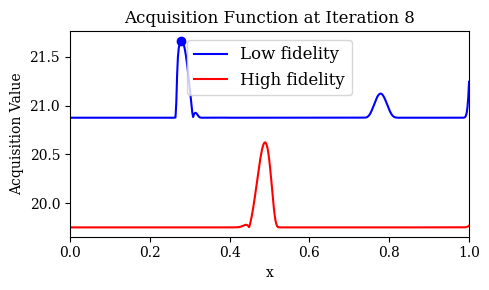

<class 'numpy.float64'>


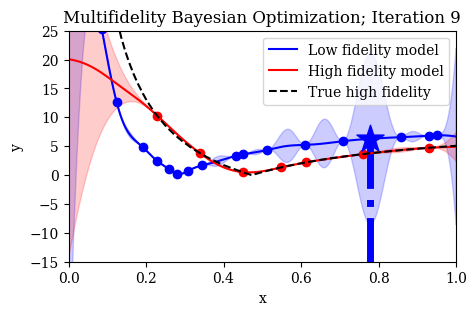

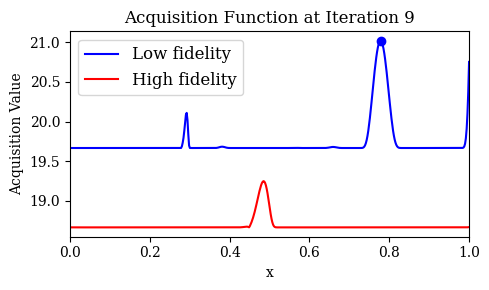

<class 'numpy.float64'>


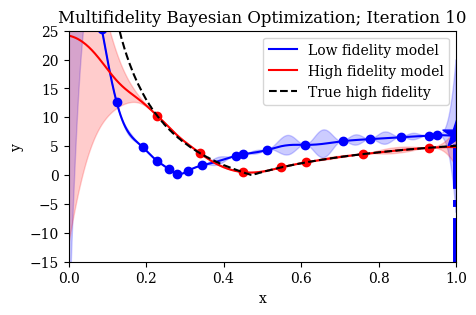

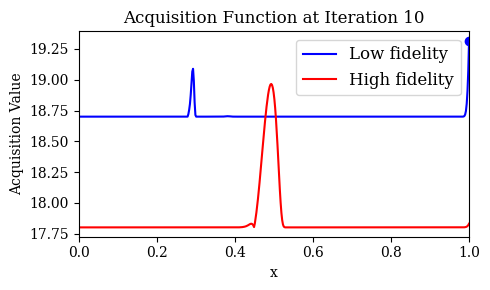

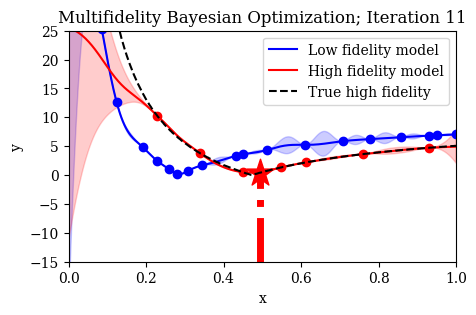

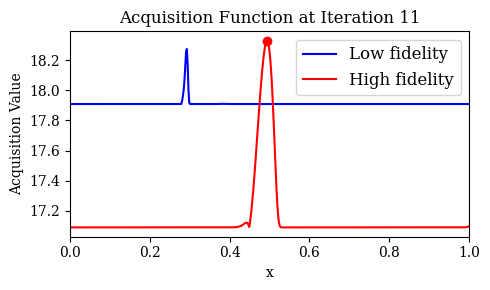

<class 'numpy.float64'>


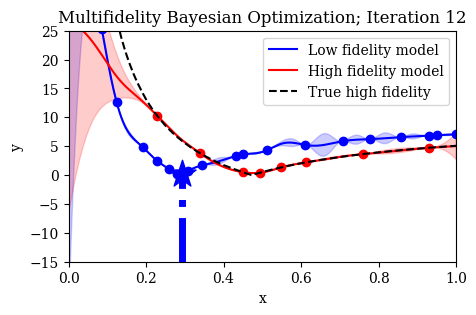

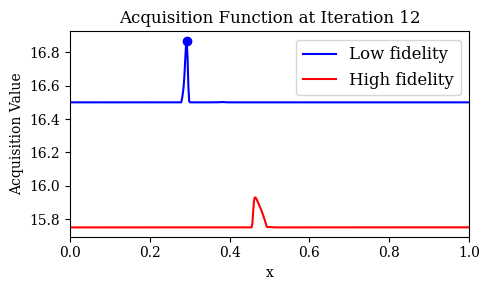

In [281]:
x, f = mfgp.run_bayes_loop(12)

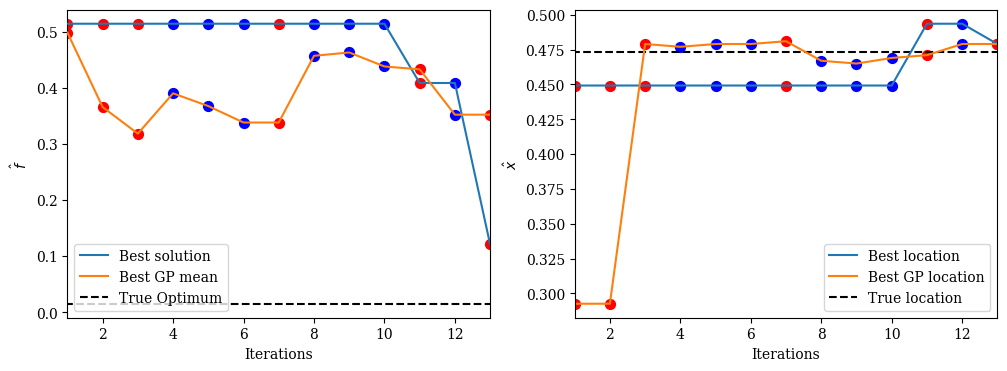

In [282]:
mfgp.plot_results()

In [231]:
def park_high(x):
    return 0.5*x[0]*(np.sqrt(1 + ((x[1] + x[2]**2)*x[3])/x[0]**2)-1) + (x[0] + 3*x[3])*np.exp(1+np.sin(x[2]))                                                                             
def park_low(x):
    return (1 + 0.1*np.sin(x[0]))*park_high(x) - 2*x[0]**2 + x[1]**2 + x[2]**2 + 0.5

In [279]:
import mf2

In [ ]:
# Branin

def lf(x):
    return mf(1.2*(x+2)) - 0.01*(3*x[:, 1] + 1) 
    
def mf(x):
    return np.sqrt(hf(x-2)) + 0.01*(2*(x[:, 0] - 0.5) - 3*(3*x[:, 1] - 1) - 1)

def hf(x):
    return (x[:, 1] - b*x[:, 0]**2 + c*x[:, 0] - r)**2 + s*(1-t)*np.cos(x[:, 0]) + s
    

In [584]:
# Define Multi-fidelity function and wrap in emukit
from emukit.core.loop.user_function import MultiSourceFunctionWrapper

b = 5.1/(4*np.pi*np.pi)
c = 5/np.pi
r, s = 6, 10
t = 1/(8*np.pi)

def lf(x):
    return mf2.currin.low(x).reshape(-1,1)

def hf(x):
    return mf2.currin.high(x).reshape(-1,1)

# Wrap the function using MultiSourceFunctionWrapper
currin = MultiSourceFunctionWrapper([lf, hf])

currin_l = currin.f[0]
currin_h = currin.f[1]

In [1]:
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": "Computer Modern",
})
FIG_SIZE = (12, 8)

NameError: name 'plt' is not defined

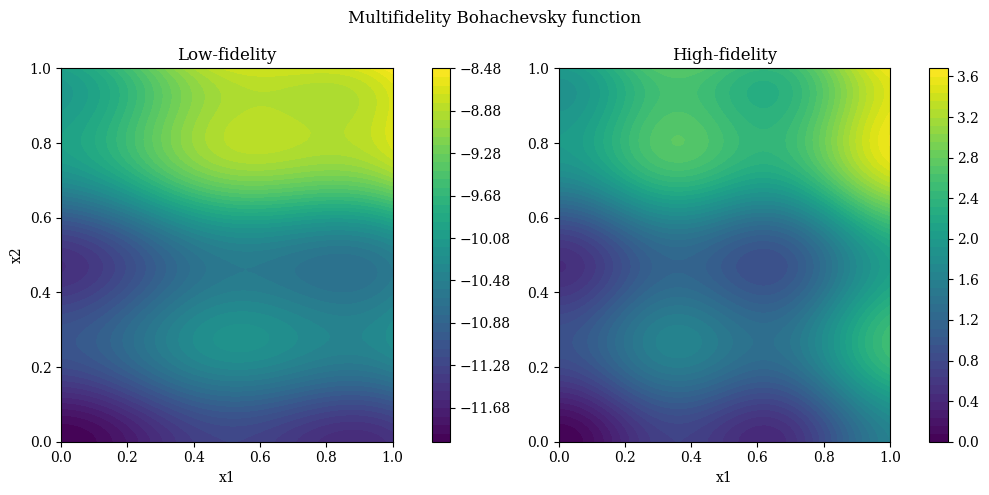

In [368]:
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)

X1, X2 = np.meshgrid(x1, x2)
x_plot = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])

Z1 = mf2.bohachevsky.low(x_plot)
Z2 = mf2.bohachevsky.high(x_plot)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
c1 = axes[0].contourf(X1, X2, Z1.reshape(X1.shape), levels=50, cmap='viridis')
c2 = axes[1].contourf(X1, X2, Z2.reshape(X1.shape), levels=50, cmap='viridis')

cbar1 = fig.colorbar(c1, ax=axes[0], orientation='vertical', fraction=0.05, pad=0.1)

cbar2 = fig.colorbar(c2, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.1)


plt.suptitle('Multifidelity Bohachevsky function')
axes[0].set_title('Low-fidelity')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[1].set_title('High-fidelity')
axes[1].set_xlabel('x1')
plt.tight_layout()
plt.show()


In [200]:
import warnings
warnings.simplefilter('always')

import warnings
warnings.filterwarnings("ignore")

In [202]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation

import GPy
from GPy.models.gp_regression import GPRegression
from emukit.multi_fidelity.kernels.linear_multi_fidelity_kernel import LinearMultiFidelityKernel
from emukit.multi_fidelity.convert_lists_to_array import convert_xy_lists_to_arrays
from emukit.model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models.linear_model import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array
from emukit.core.loop.user_function import MultiSourceFunctionWrapper
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel
from emukit.core import ParameterSpace, ContinuousParameter, InformationSourceParameter
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization.multi_source_acquisition_optimizer import MultiSourceAcquisitionOptimizer
from emukit.core.optimization import GradientAcquisitionOptimizer

from scipy.integrate import solve_ivp

import mf2

In [204]:
from emukit.core.optimization.optimizer import OptLbfgs

In [206]:
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": "Computer Modern",
})
FIG_SIZE = (12, 8)

In [290]:
class multifidelityUCB:
    def __init__(self, lf, hf, ndim=1, negate=False, noise=0.1):
        self.LF = lf
        self.HF = hf
        self.multifidelity = MultiSourceFunctionWrapper([lf, hf])
        self.iterates = []
        self.GP_iterates = []
        self.ndim = ndim
        self.negate = negate
        self.fidelity_list = []
        self.l_noise = noise

    def set_initial_data(self, n1, n2, bounds):
        np.random.seed(12346)
        x_low = np.random.rand(n1,self.ndim)
        x_high = x_low[:n2, :]
        y_low = self.multifidelity.f[0](x_low)
        y_high = self.multifidelity.f[1](x_high)
        self.x_array, self.y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])
        self.n_init = n1+n2
        
        if self.ndim==1:
            # Bounds
            lb, ub = bounds
            self.bounds = bounds
            x_plot = np.linspace(lb, ub, 500)[:, None]
            
        if self.ndim==2:
            self.bounds = bounds
            x1_range = np.linspace(0, 1, 200)
            x2_range = np.linspace(0, 1, 200)
            # Create mesh grid from x1 and x2 ranges
            X1, X2 = np.meshgrid(x1_range, x2_range)
            x_plot = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
            self.X1, self.X2 = X1, X2

        self.x_plot = x_plot
        self.x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
        self.x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)

    def set_model(self, x_array=None, y_array=None, ker='rbf'):
        if x_array==None:
            x_array = self.x_array
        if y_array==None:
            y_array = self.y_array
        
        n_fidelities = 2
        if self.ndim==1:
            lb, ub = self.bounds
            self.parameter_space = ParameterSpace([ContinuousParameter('x', lb, ub), InformationSourceParameter(n_fidelities)])
        else:
            paramspace = []
            for i in range(self.ndim):
                lb, ub = self.bounds[i]
                paramspace.append(ContinuousParameter('x'+str(i+1), 0, 1))
            paramspace.append(InformationSourceParameter(n_fidelities))
            self.parameter_space = ParameterSpace(paramspace)
        print(ker)
        if ker=='rbf':
            print('yes')
            kern_low = GPy.kern.RBF(self.ndim)
            kern_low.lengthscale.constrain_bounded(0.01, 0.5)
            
            kern_err = GPy.kern.RBF(self.ndim)
            kern_err.lengthscale.constrain_bounded(0.01, 0.5)

        else:
            kern_low = GPy.kern.Matern52(self.ndim)
            kern_low.lengthscale.constrain_bounded(0.005, 0.5)
            
            kern_err = GPy.kern.Matern52(self.ndim)
            kern_err.lengthscale.constrain_bounded(0.005, 0.5)
            
            
        multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
        gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)
        
        gpy_model.likelihood.Gaussian_noise.fix(self.l_noise)
        gpy_model.likelihood.Gaussian_noise_1.fix(0)
        
        self.model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
        self.model.optimize()

    def set_acquisition(self, beta, cost_ratio):
        self.cost_ratio = cost_ratio
        self.beta = beta
        self.acquisition = CustomMultiFidelityAcquisition(self.model, 
                                                          self.parameter_space,                                                          
                                                          ei_beta = beta)
    def init_bayes_loop(self):
        initial_loop_state = create_loop_state(self.x_array, self.y_array)
        acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(self.parameter_space), self.parameter_space)
        self.candidate_point_calculator = SequentialPointCalculator(self.acquisition, acquisition_optimizer)
        self.n_hf_evals, self.n_lf_evals = 0,0
        self.iterates = []
        self.GP_iterates = []

    def run_bayes_loop(self, n_iter, min_hf_evals=1, conv_plot=False):
        self.n_iter = n_iter
        self.min_hf_evals = min_hf_evals
        #if n_restarts==None:
        #    n_restarts = 5 * self.ndim
        #else:
        #    n_restarts = n_restarts * self.ndim
            
        #sol = np.min(self.model.Y[self.model.X[:, -1] == 1])
        #hf = self.model.X[self.model.X[:, -1] == 1][:, :-1]
        #loc = hf[np.argmin(self.model.Y[self.model.X[:, -1] == 1])]
        #self.iterates.append([loc, sol])
        
        #self.GP_iterates.append()
        for i in range(n_iter):
            #xnext = self.candidate_point_calculator.compute_next_points(self.model)[:, :-1]
            #opt = OptLbfgs(np.array([self.bounds]))
            #x = np.random.rand(n_restarts, self.ndim)
            #def acq_opt(x):
            #    x = np.array([np.hstack([x,0])])
            #    return -self.acquisition.evaluate(x)
            #opt_acq_list=[]
            #min_acq_list = []
            #
            #for i in x:
            #    loc, min = opt.optimize(i, acq_opt)
            #    opt_acq_list.append(loc)
            #    min_acq_list.append(min)

            #xnext = opt_acq_list[np.argmin(min_acq_list)]
            #acq_next = -np.argmin(min_acq_list)

            xnext = self.candidate_point_calculator.compute_next_points(self.model)[:, :-1]
            mean_l, variance_l = self.model.predict(np.array([np.hstack([xnext[0],0])]))
            mean_h, variance_h = self.model.predict(np.array([np.hstack([xnext[0],1])]))
            error = abs(mean_h - mean_l)
            
            self.gamma = error * np.sqrt(self.cost_ratio)
            
            if self.beta * np.sqrt(variance_l) > self.gamma:
                fidelity = 0
                self.n_lf_evals += 1
            else:
                fidelity = 1
                self.n_hf_evals += 1
        
            self.fidelity_list.append(fidelity)
            xnew = np.hstack([xnext[0], fidelity])
            ynew = self.multifidelity.f[fidelity](xnext)
            Y = np.vstack([self.model.Y, ynew])
            X = np.vstack([self.model.X, xnew])
            if self.ndim==1:
                self.plot_acquisition(xnew, i+1)
            if self.ndim == 2:
                self.plot_acquisition2D(xnew, i+1)
            self.model.set_data(X, Y)
            if self.ndim==1:
                self.plot_optimization(i+1)
            self.model.optimize()
                

            best_so_far = np.max(self.model.Y[self.model.X[:, -1] == 1])
            hf = self.model.X[self.model.X[:, -1] == 1][:, :-1]
            best_loc = hf[np.argmax(self.model.Y[self.model.X[:, -1] == 1])]
            mean, var = self.model.predict(self.x_plot_high)
            best_mean = np.max(mean)
            best_mean_loc = self.x_plot_high[np.argmax(mean), :-1]
            iterate = np.hstack([best_loc, best_so_far])
            GP_iterate = np.hstack([best_mean_loc, best_mean])
            self.iterates.append(iterate)
            self.GP_iterates.append(GP_iterate)

        y_last = self.multifidelity.f[1](best_mean_loc)

        if best_mean > best_so_far:
            if y_last[0] > best_so_far:
                best_so_far = y_last[0]
                best_loc = best_mean_loc
    
            iterate = np.hstack([best_loc, best_so_far])
            self.iterates.append(iterate)
            self.fidelity_list.append(1)
            self.GP_iterates.append(self.GP_iterates[-1])
            
        else:
            self.min_hf_evals = 0

        self.GP_iterates = np.array(self.GP_iterates)
        self.iterates = np.array(self.iterates)

        if self.negate:
            best_so_far = -best_so_far
        
        return best_loc, best_so_far

    def plot_with_error_bars(self, x, mean, var, color, label):
            plt.plot(x, mean, color=color, label=label)
            plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                            alpha=0.2, color=color)
    def true_model(self):
        self.true_model = self.multifidelity.f[1](self.x_plot)
        self.max = np.max(self.true_model)
        self.loc = self.x_plot[np.argmax(self.true_model)]
        if self.negate:
            self.true_model = -self.true_model
            self.max = -self.max
        
        
    def plot_optimization(self, iter):
        plt.figure(figsize=(7,4))
        colours = ['b', 'r']
        is_high_fidelity = self.model.X[:, -1] == 1
        x_low = self.model.X[~is_high_fidelity, :-1]
        y_low = self.model.Y[~is_high_fidelity]
        x_high = self.model.X[is_high_fidelity, :-1]
        y_high = self.model.Y[is_high_fidelity]
    
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)

        if self.negate:
            mean_low = -mean_low
            mean_high = -mean_high
            y_low = -y_low
            y_high = -y_high
            
        #plt.figure(figsize=FIG_SIZE)
        self.plot_with_error_bars(self.x_plot_high[:, :-1], mean_low, var_low, 'b', label='Low-fidelity GP')
        self.plot_with_error_bars(self.x_plot_high[:, :-1], mean_high, var_high, 'r', label='High-fidelity GP')
        plt.plot(self.x_plot, self.true_model, 'k--', label='True model')
        plt.scatter(x_low, y_low, color='b')
        plt.scatter(x_high, y_high, color='r')
    
        xnew = self.model.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,0])

        if self.negate:
            ynew = -ynew
        plt.scatter(xnew[0, 0], 
                    ynew, 
                    color=colours[fidelity_idx], marker='*', s=420)
        
        plt.vlines(xnew[0,0], -15, ynew, linestyle='-.', linewidth=5, color=colours[fidelity_idx])
        
        plt.legend()
        plt.title('Multifidelity Bayesian Optimization; Iteration {}'.format(iter))
        plt.xlim(0, 1)
        plt.ylim(-15,25)
        plt.xlabel('x')
        plt.ylabel('y');
        plt.show()

    def plot_acquisition(self, xnew, iter):
        plt.figure(figsize=(6.5,4))
        colours = ['b', 'r']
        acq_low, acq_high, error = self.acquisition.acquisition_low_high(self.x_plot_low, self.x_plot_high)
        mean_l = self.acquisition.acquisition_low_mean(self.x_plot_low)
        plt.plot(self.x_plot_low[:, 0], acq_low, 'b', label='Low-fidelity')
        plt.plot(self.x_plot_low[:, 0], acq_high, 'r', label='High-fidelity')
        plt.plot(self.x_plot_low[:, 0], self.acquisition.evaluate(self.x_plot_high), 'g', linestyle='--', label='Combined')
        xnew = np.array([xnew])
        fidelity_idx = int(xnew[0, -1])
        plt.scatter(xnew[0, :-1], 
                   self.acquisition.evaluate(xnew), 
                    color=colours[fidelity_idx])
        plt.plot(self.x_plot_low[:, 0], mean_l + self.gamma + error, color='k', linestyle='--', label='Gamma threshold')
        
        plt.legend()
        plt.title('Acquisition Function at Iteration {}'.format(iter))
        plt.xlabel('x')
        plt.xlim(0, 1)
        plt.ylabel('Acquisition Value')
        plt.tight_layout()
        plt.show()

    def plot_acquisition2D(self, xnew, iter):
        colours = ['b', 'r']
        plt.figure(figsize=(8, 6))
        contour = plt.contourf(self.X1, self.X2, self.acquisition.evaluate(self.x_plot_high).reshape(self.X1.shape), levels=50, cmap='viridis')
        cbar = plt.colorbar(contour)
        cbar.set_label('Multi-fidelity UCB')
        xnew = np.array([xnew])
        fidelity_idx = int(xnew[0, -1])
        plt.scatter(xnew[:, 0], 
                    xnew[:, 1], 
                    color=colours[fidelity_idx], marker='*', s=220, label='next location')
        plt.legend()
        plt.title('Acquisition Function at Iteration {}'.format(iter))
        plt.xlabel('x1')
        plt.xlim(0,1)
        plt.ylabel('x2')
        plt.show()

    def plot_optimization2D(self, iter):
        colours = ['b', 'r']
        is_high_fidelity = loop.loop_state.X[:, -1] == 1
        x_low=loop.loop_state.X[~is_high_fidelity, :-1]
        y_low=loop.loop_state.Y[~is_high_fidelity]
        x_high=loop.loop_state.X[is_high_fidelity, :-1]
        y_high=loop.loop_state.Y[is_high_fidelity]
    
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
    
        plt.figure(figsize=(8,6))
        plt.contourf(self.X1, self.X2, mean_high.reshape(self.X1.shape), levels=50, cmap='viridis')
        plt.colorbar(label="Multifidelity GP Mean")
        plt.scatter(x_low[:, 0], x_low[:, 1], color='b', label='Low fidelity points')
        plt.scatter(x_high[:, 0], x_high[:, 1], color='r', label='High fidelity points')
    
        xnew = loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,:-1])
        plt.scatter(xnew[:, 0], 
                    xnew[:, 1], 
                    color=colours[fidelity_idx], marker='*', s=220, label='next location')
        plt.legend()
        plt.title('Multifidelity Bayesian Optimization; Iteration {}'.format(self.loop.loop_state.iteration))
        plt.xlabel('x1')
        plt.ylabel('x2');
        plt.show()

    def true_max(self):
        y = self.multifidelity.f[1](self.x_plot)
        max = np.max(y)
        loc = self.x_plot[np.argmax(y)]        
        return max, loc


    def plot_results(self):
        colours = ['b', 'r']
        max, loc = self.max, self.loc
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        iterates = self.iterates[:,-1]
        GP_iterates = self.GP_iterates[:,-1]
        if self.negate:
            iterates = -iterates
            GP_iterates = -GP_iterates

        axes[0].plot(np.arange(1, self.n_iter+self.min_hf_evals+1, 1), iterates, label='Best solution')
        axes[0].plot(np.arange(1, self.n_iter+self.min_hf_evals+1, 1), GP_iterates, label='Best GP mean')
        axes[0].set_xlim(1, self.n_iter+self.min_hf_evals)
        axes[0].hlines(max, 0, self.n_iter+self.min_hf_evals, 'k', linestyle='--', label='True optimum')
        for i in range(len(iterates)):
            axes[0].scatter(i+1, iterates[i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
            axes[0].scatter(i+1, GP_iterates[i], color = colours[self.fidelity_list[i]], zorder=2, s=50)
        axes[0].legend()
        axes[0].set_xlabel('Iterations')
        axes[0].set_ylabel(r'$\hat{f}$')

        if self.ndim==1:
            axes[1].plot(np.arange(1, self.n_iter+self.min_hf_evals+1, 1), self.iterates[:,0], label='Best location')
            axes[1].plot(np.arange(1, self.n_iter+self.min_hf_evals+1, 1), self.GP_iterates[:,0], label='Best GP location')
            axes[1].set_xlim(1, self.n_iter+self.min_hf_evals)
            axes[1].hlines(loc, 0, self.n_iter+self.min_hf_evals, 'k', linestyle='--', label='True location')
            for i in range(len(iterates)):
                axes[1].scatter(i+1, self.iterates[:,0][i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
                axes[1].scatter(i+1, self.GP_iterates[:,0][i], color = colours[self.fidelity_list[i]], zorder=2, s=50)
            axes[1].legend()
            axes[1].set_xlabel('Iterations')
            axes[1].set_ylabel(r'$\hat{x}$')
        else:
            norm_iterates = [np.linalg.norm(i - loc) for i in self.iterates[:,:-1]]
            norm_GP_iterates = [np.linalg.norm(i - loc) for i in self.GP_iterates[:,:-1]]
            axes[1].plot(np.arange(1, self.n_iter+self.min_hf_evals+1, 1), norm_iterates, label='Best location')
            axes[1].plot(np.arange(1, self.n_iter+self.min_hf_evals+1, 1), norm_GP_iterates, label='Best GP location')
            for i in range(len(iterates)):
                axes[1].scatter(i+1, norm_iterates[i], color = colours[self.fidelity_list[i]], zorder=1, s=50)
                axes[1].scatter(i+1, norm_GP_iterates[i], color = colours[self.fidelity_list[i]], zorder=2, s=50)
            axes[1].set_xlim(1, self.n_iter+self.min_hf_evals)
            axes[1].legend()
            axes[1].set_xlabel('Iterations')
            axes[1].set_ylabel(r'$|\hat{x} - x_*|$')

In [292]:
# Define custom acquisition model

from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel
import numpy as np


class CustomMultiFidelityAcquisition(Acquisition):
    def __init__(self, model: IModel, space, ei_beta=15):
        """
        Custom acquisition function for multi-fidelity optimization.

        :param model: Multi-fidelity model (e.g., a multi-fidelity GP)
        :param space: Search space over which the optimization is performed
        :param cost_function: Optional cost function that assigns a cost to each fidelity level
        """
        super().__init__()
        self.model = model  # Multi-fidelity GP model
        self.space = space  # The parameter space (search space)
        self.ei_beta = ei_beta
    
    @property
    def has_gradients(self):
        # If gradients are implemented, return True. Otherwise, return False.
        return False

    def evaluate(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function at the given points.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Acquisition values (np.ndarray of shape (n_points,))
        """
        # Multi-fidelity model's prediction (mean, variance) at point x
        xcopy_l, xcopy_h = x.copy(), x.copy()
        x_low = xcopy_l
        x_low[:, -1] = np.zeros(xcopy_l[:, -1].shape)
        x_high = xcopy_h
        x_high[:, -1] = np.ones(xcopy_h[:, -1].shape)
        
        mean_l, variance_l = self.model.predict(x_low)
        mean_h, variance_h = self.model.predict(x_high)

        acq_l = mean_l + self.ei_beta*(np.sqrt(variance_l)) + abs(mean_h - mean_l)
        acq_h = mean_h + self.ei_beta*(np.sqrt(variance_h))
        acquisition_value = np.array([np.min([acq_l[i], acq_h[i]]) for i in range(len(acq_l))]).reshape(-1,1)
        return acquisition_value

    def acquisition_low_high(self, x_low, x_high):
        mean_h, variance_h = self.model.predict(x_high)
        mean_l, variance_l = self.model.predict(x_low)
        error = abs(mean_h - mean_l)
        return [mean_l + self.ei_beta* np.sqrt(variance_l) + error,
               mean_h + self.ei_beta * np.sqrt(variance_h), error]
    
    def acquisition_low_mean(self, x_low):
        mean_l, variance_l = self.model.predict(x_low)
        return mean_l


    def evaluate_with_gradients(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function and return gradients.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Tuple of (acquisition values, gradients)
        """
        raise NotImplementedError("Gradients are not implemented for this acquisition function.")

In [294]:
def low_fidelity_toy(x):
    return 0.5*high_fidelity_toy(x) + 10*(x-0.5) -5

def high_fidelity_toy(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

def lf(x):
    return -low_fidelity_toy(x)

def hf(x):
    return -high_fidelity_toy(x)

In [296]:
mfUCB = multifidelityUCB(lf, hf, ndim=1, negate=True, noise=0.0)
mfUCB.set_initial_data(12, 3, np.array([0, 1]))
mfUCB.set_model()
#mfgp.plot_model()
mfUCB.set_acquisition(50, 0.0001)
mfUCB.true_model()
mfUCB.init_bayes_loop()

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


rbf
yes


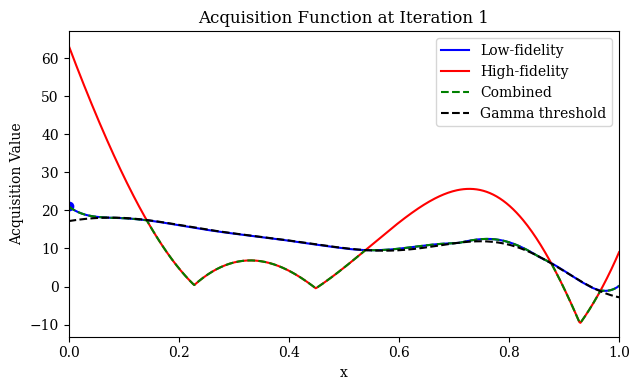

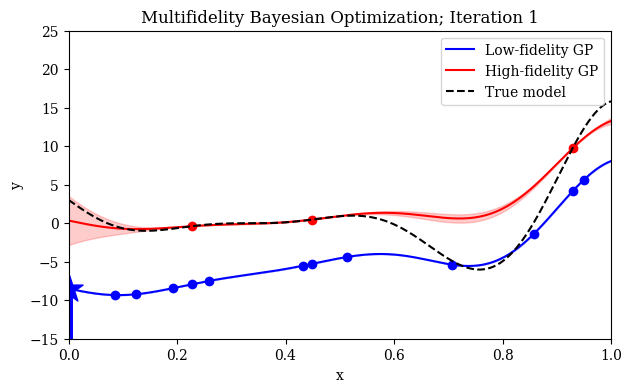

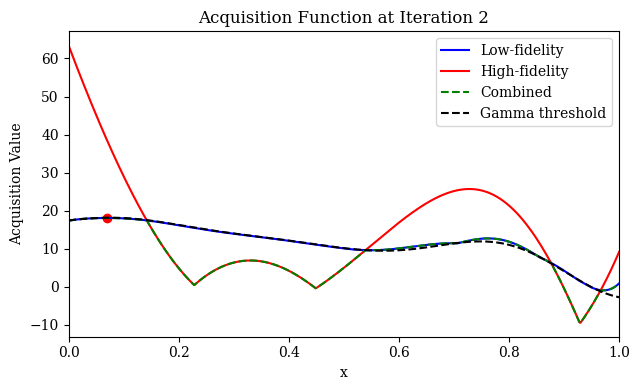

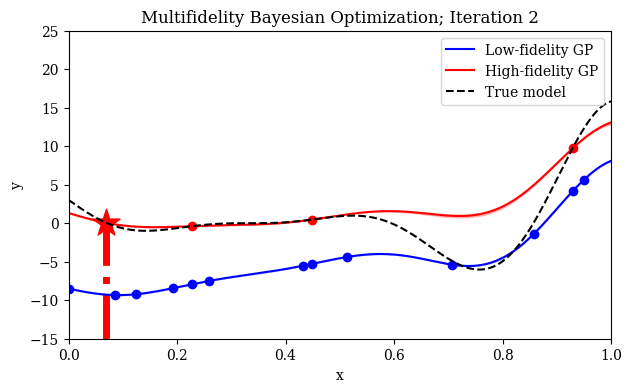

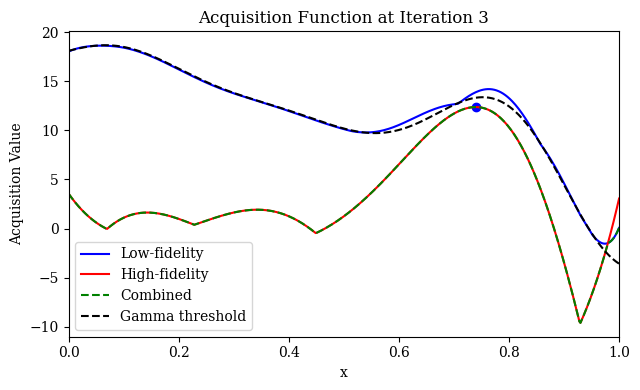

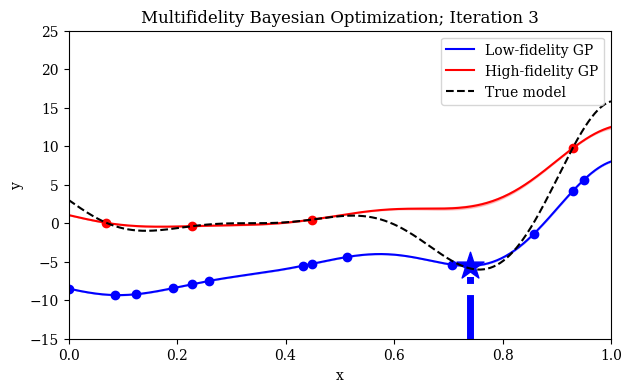

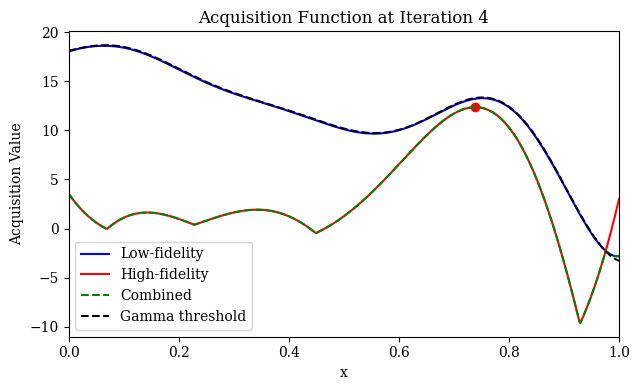

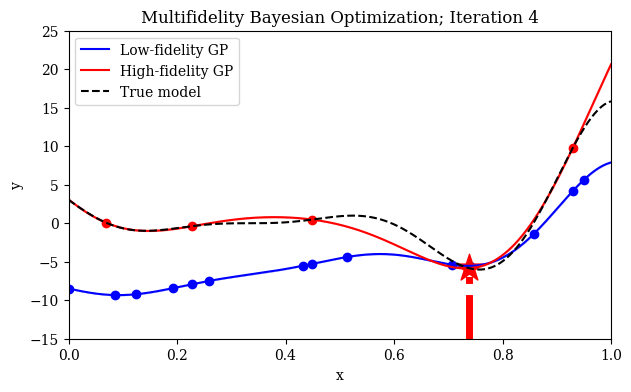

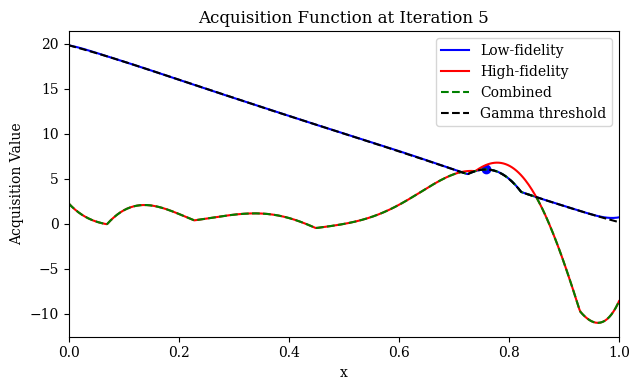

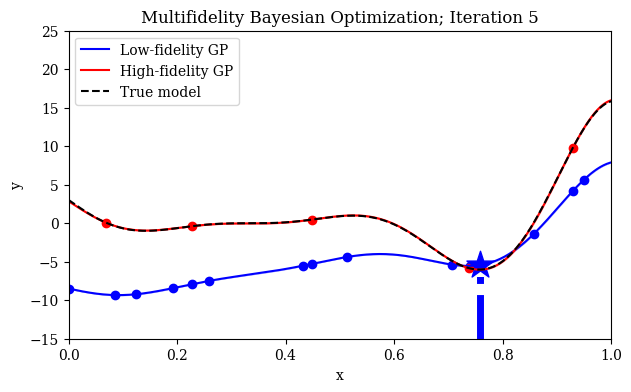

In [298]:
x, f = mfUCB.run_bayes_loop(5)

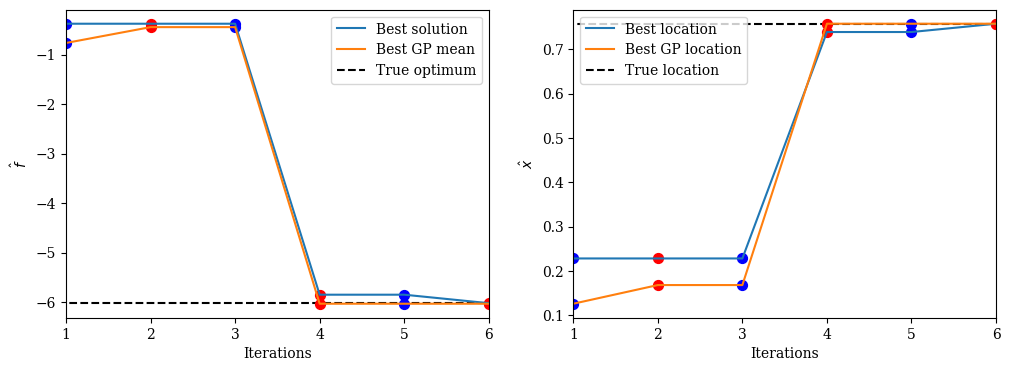

In [300]:
mfUCB.plot_results()

In [115]:
mfUCB.n_hf_evals

3

In [117]:
mfUCB.n_lf_evals

2

In [302]:
x, f

(array([0.75751503]), -6.020702165706032)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


rbf
yes


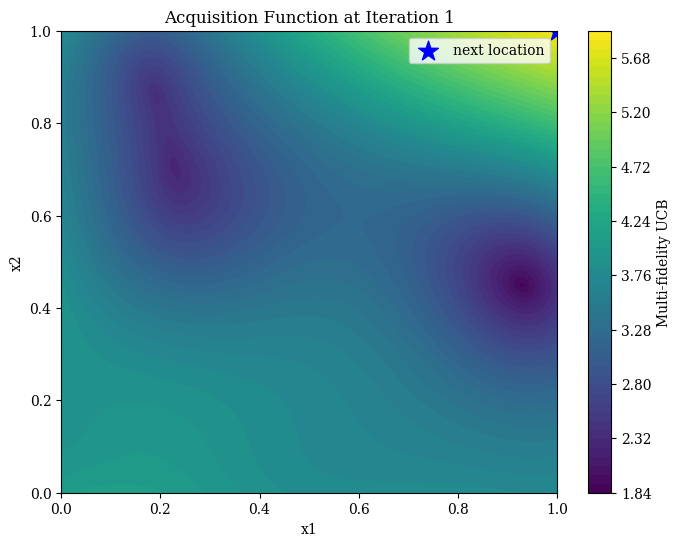

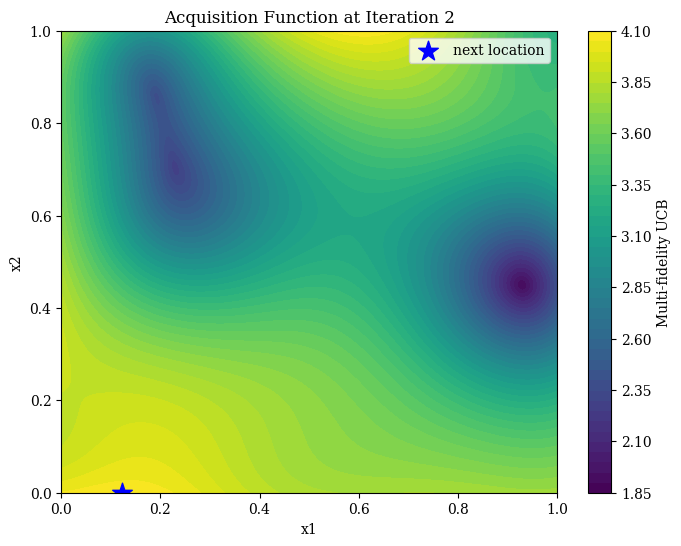

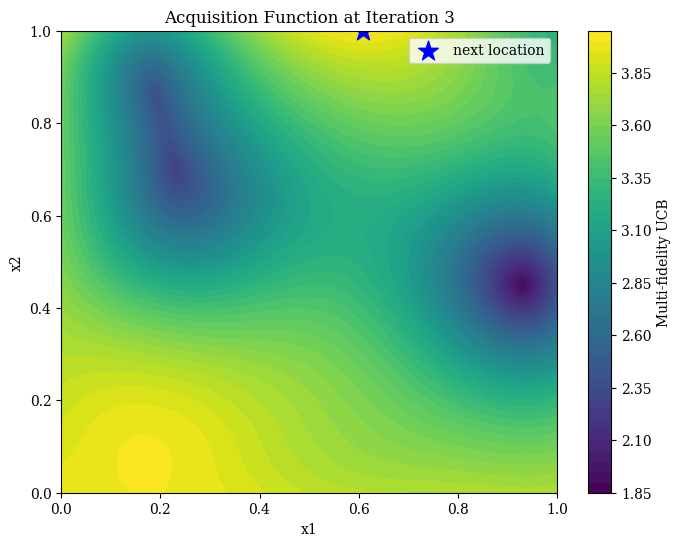

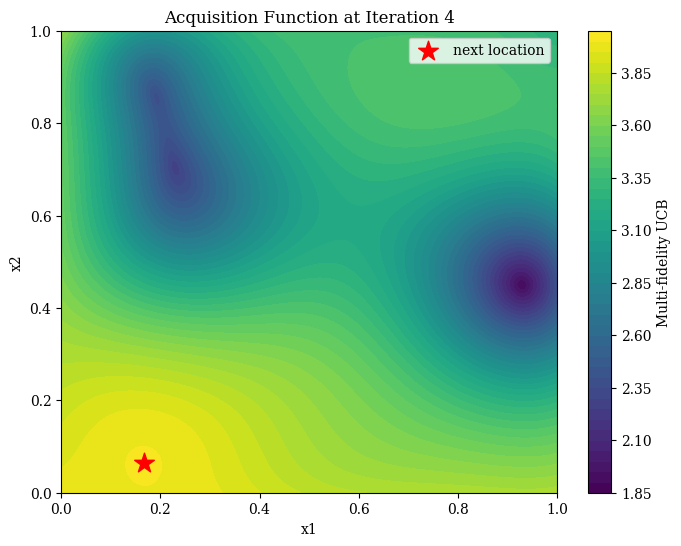

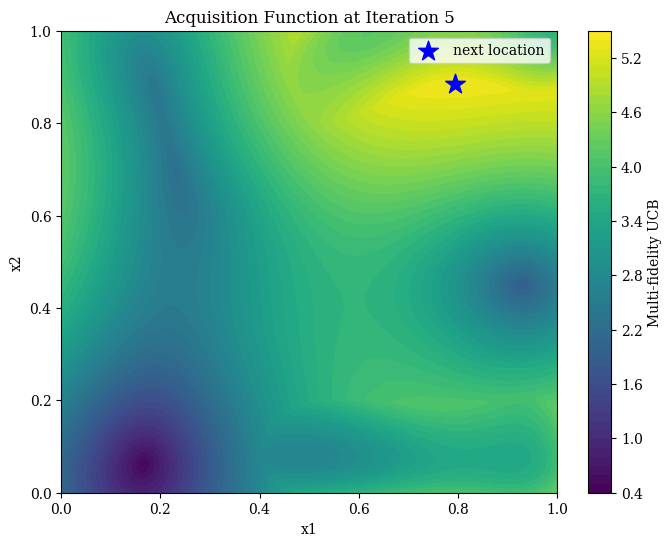

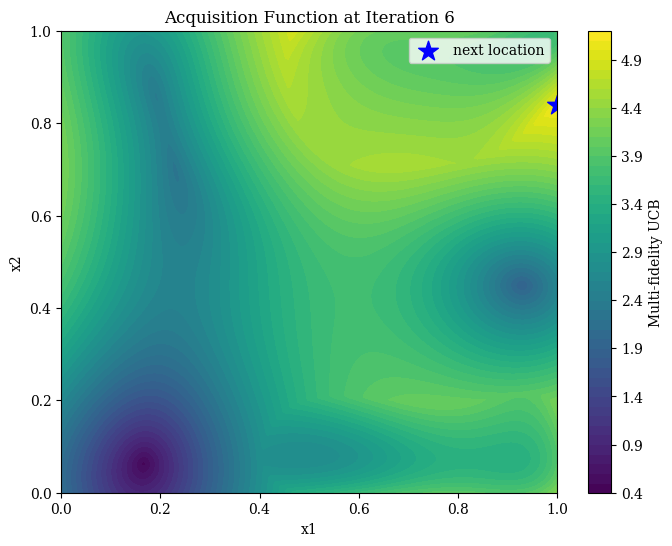

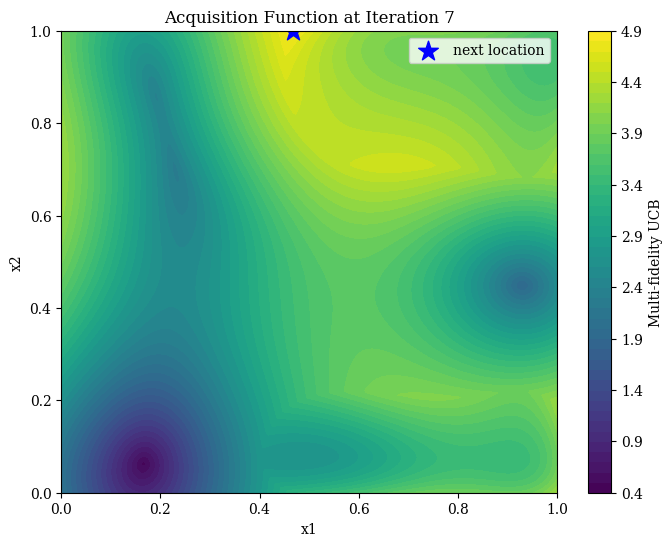

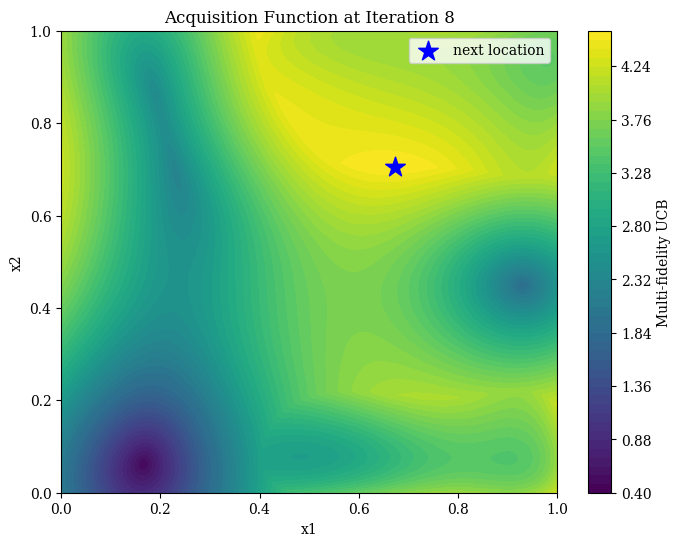

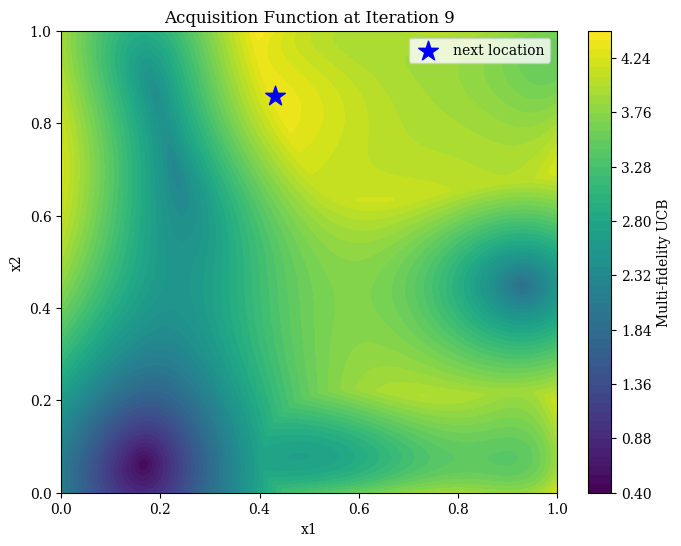

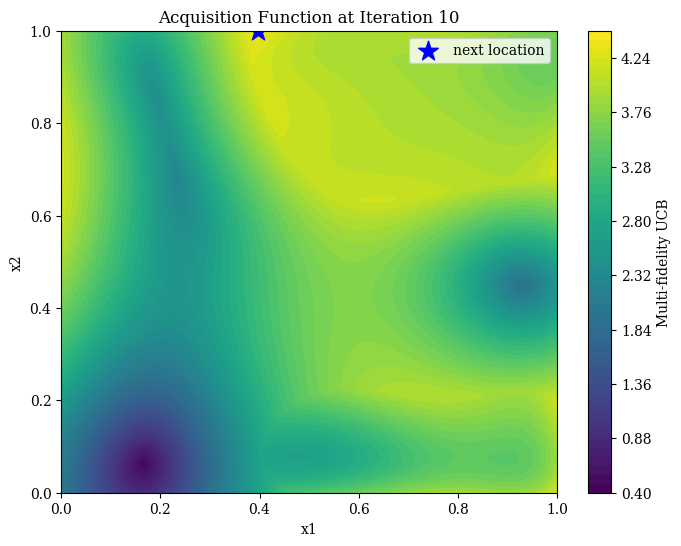

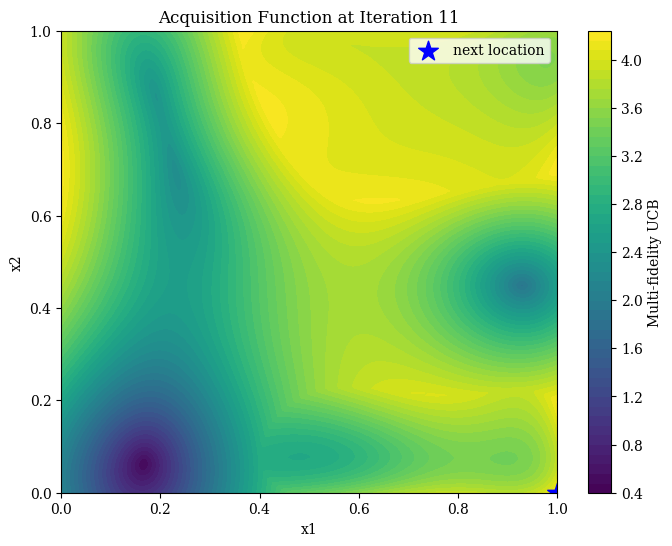

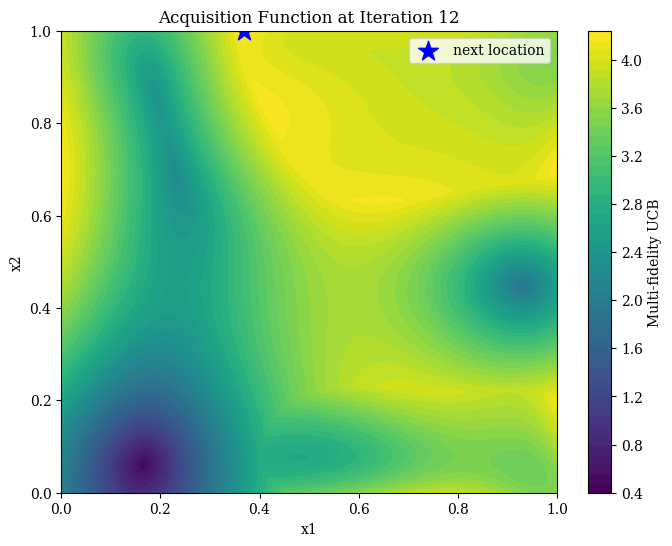

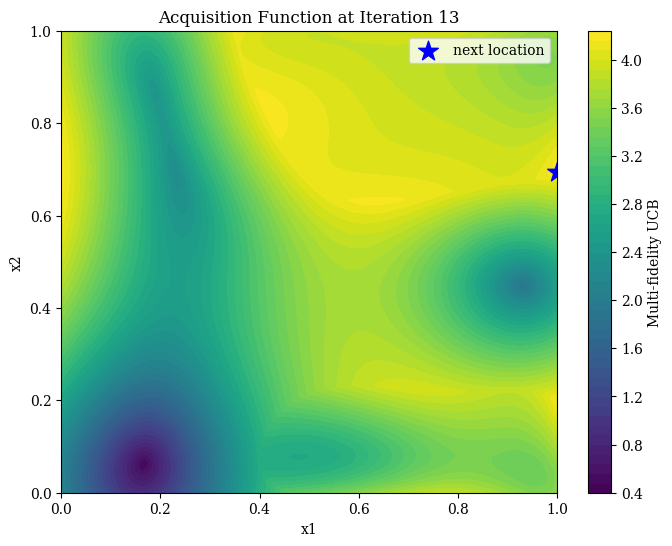

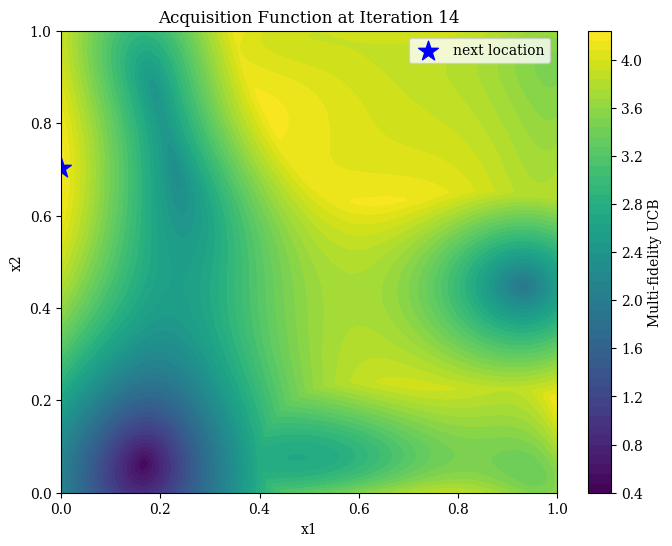

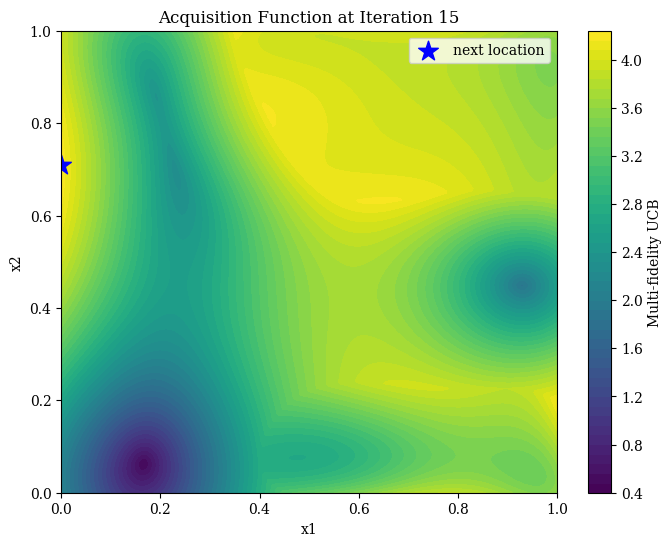

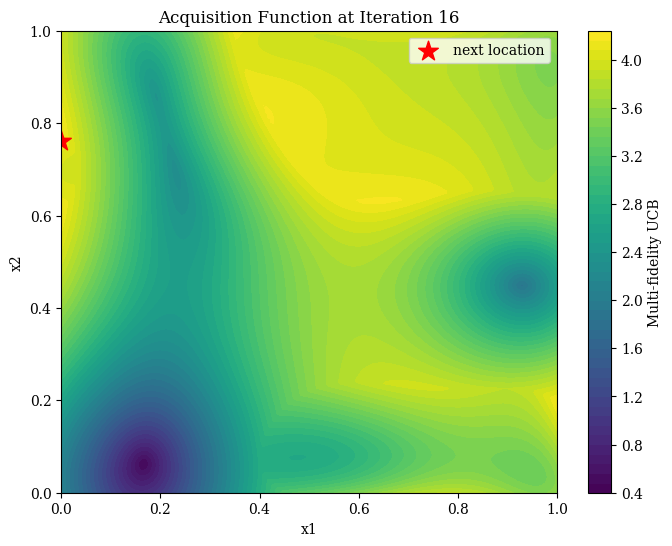

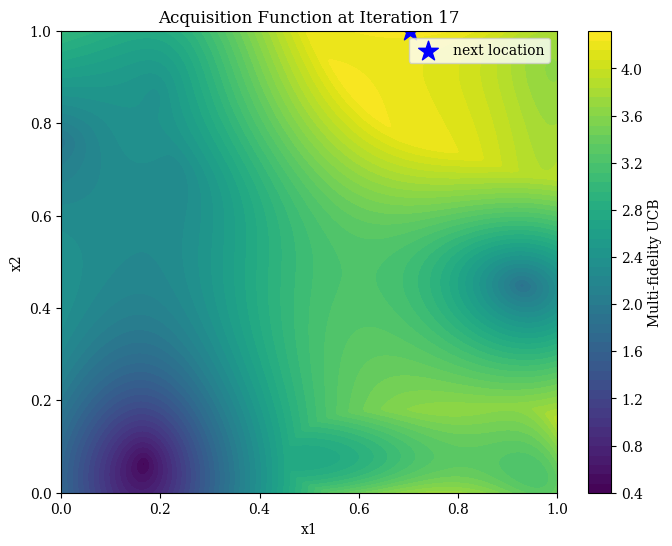

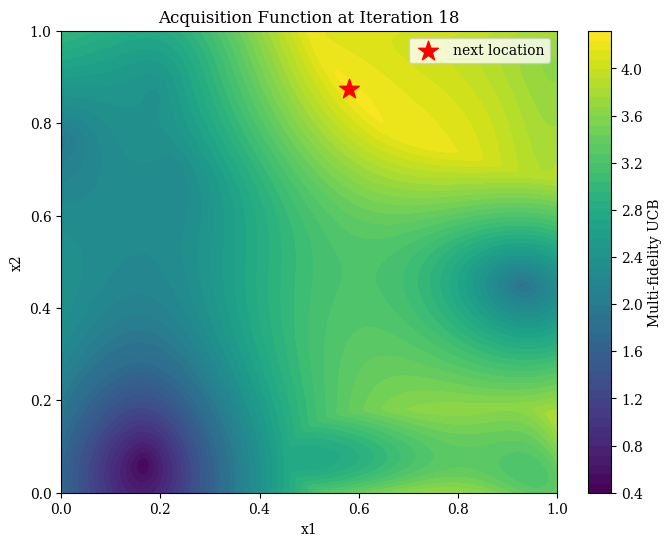

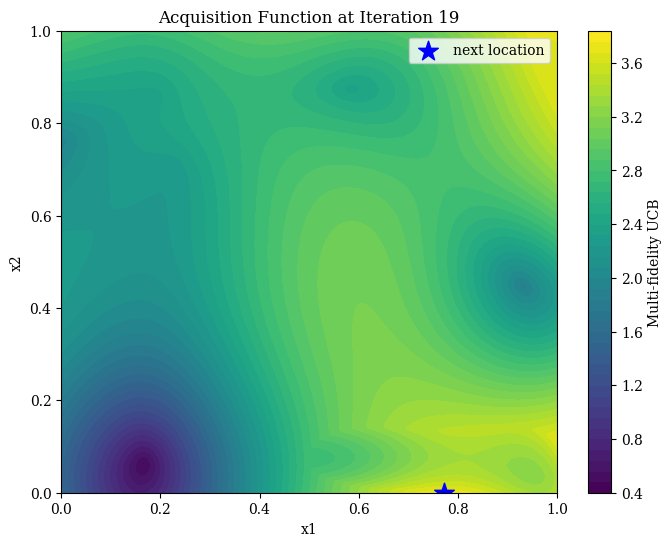

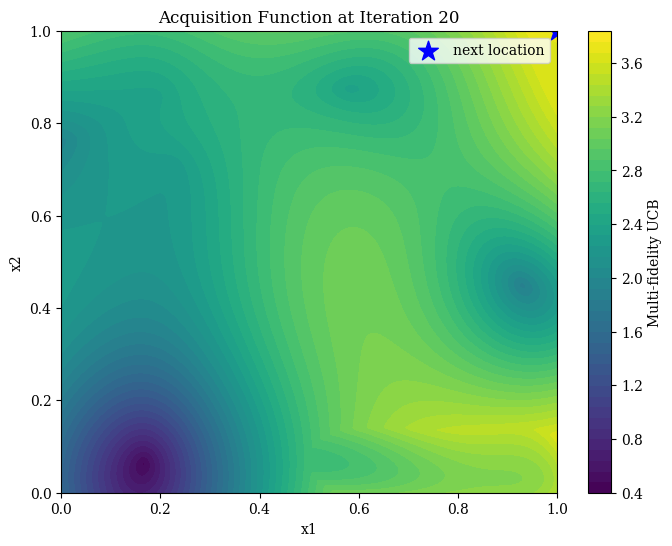

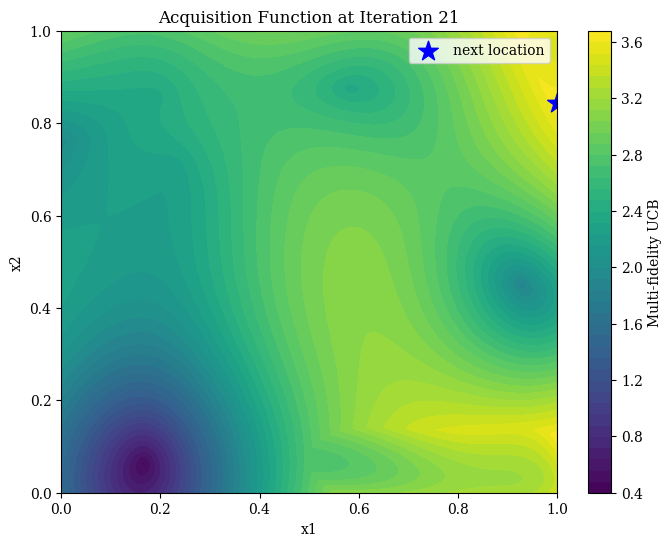

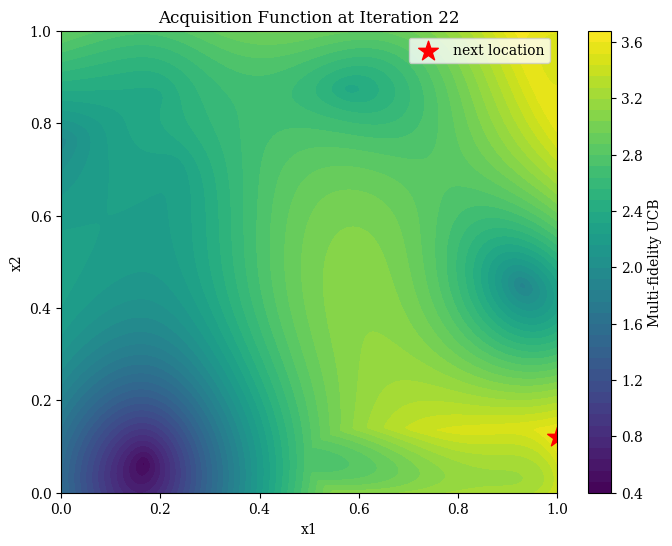

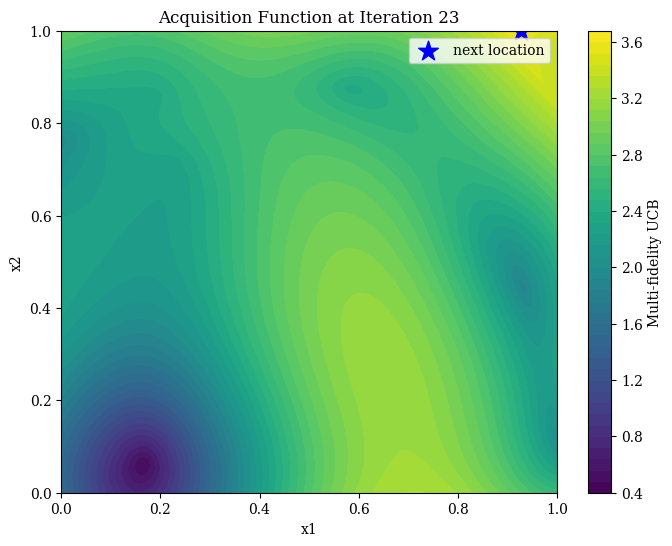

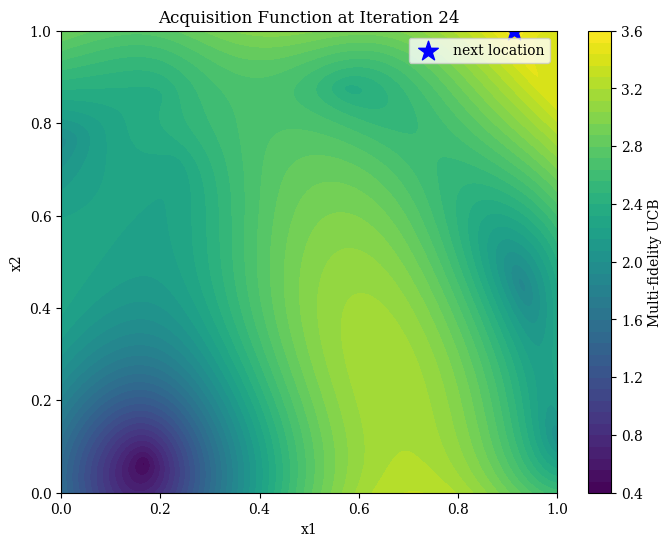

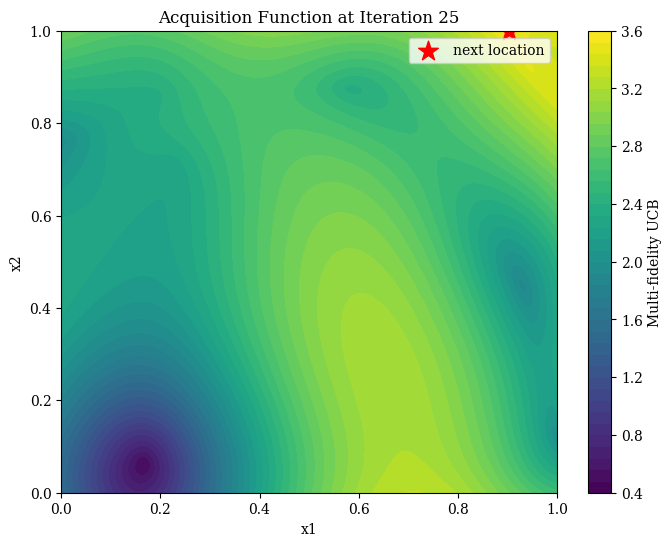

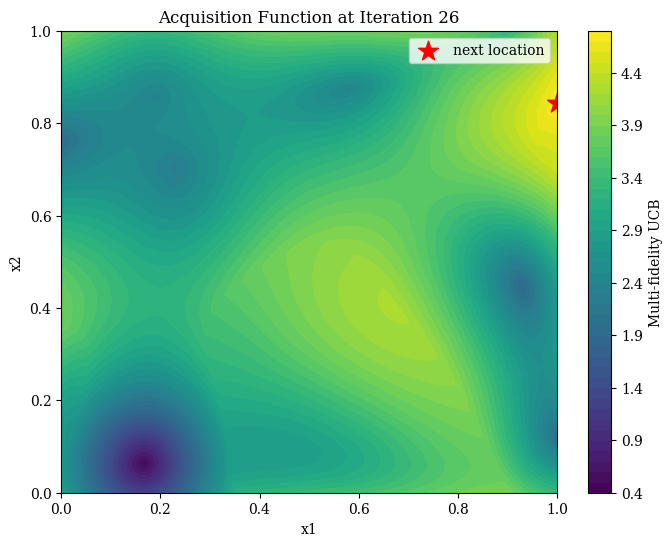

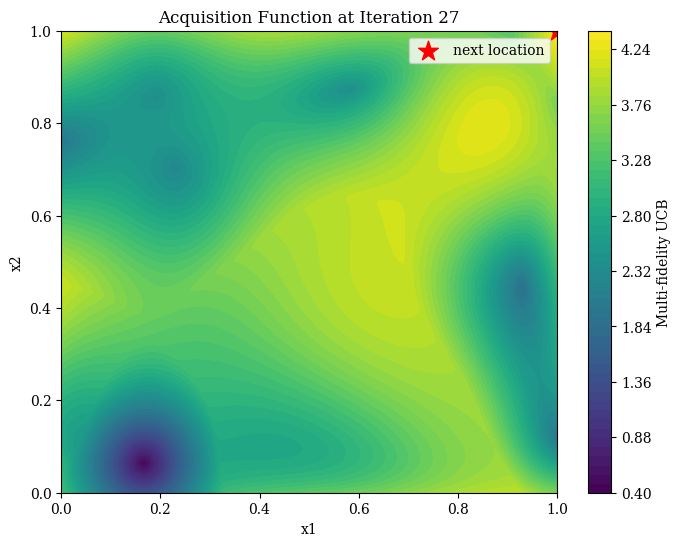

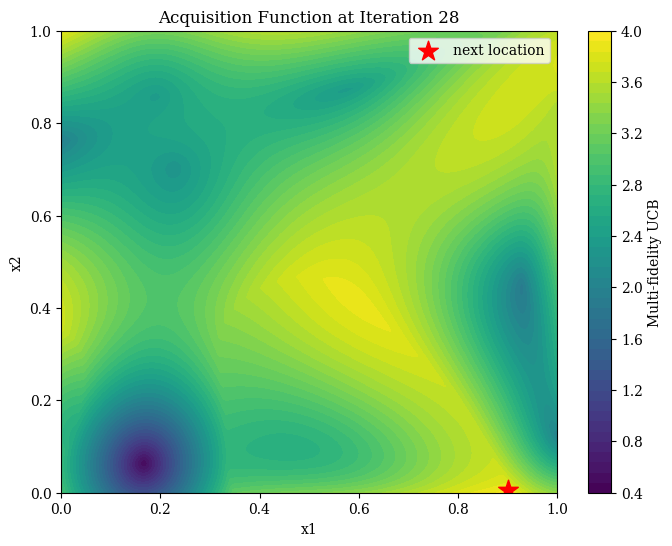

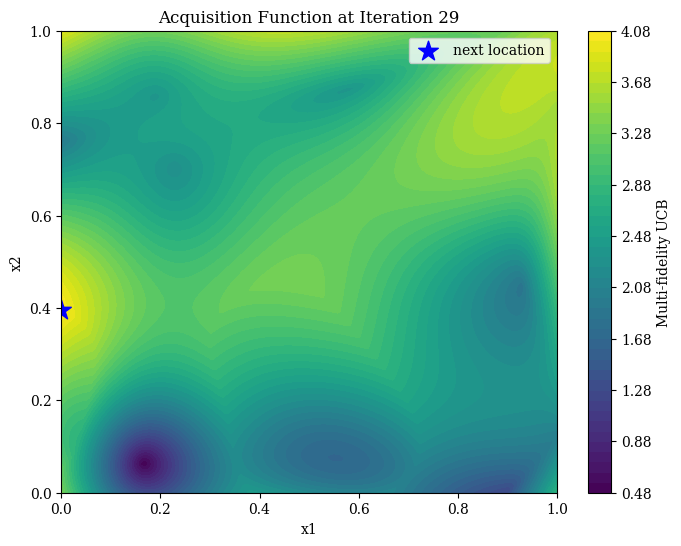

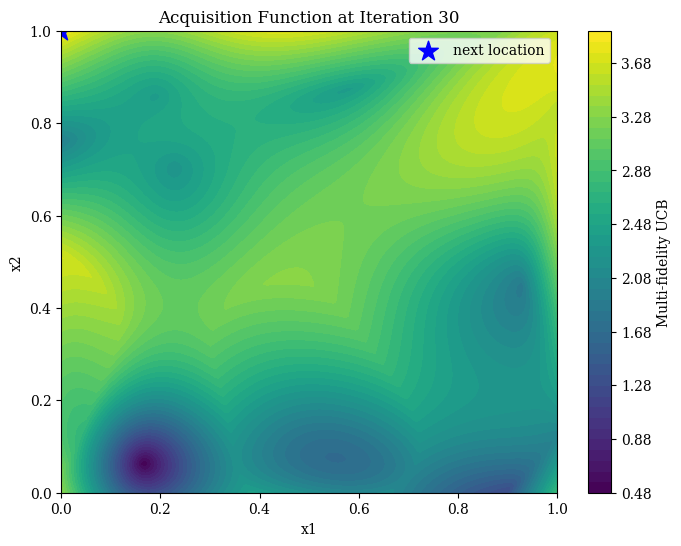

(ObsAr([1., 1.]), array(3.6))

In [362]:
def lf(x):
    return mf2.bohachevsky.low(x).reshape(-1,1)

def hf(x):
    return mf2.bohachevsky.high(x).reshape(-1,1)

mfUCB = multifidelityUCB(lf, hf, ndim=2)
mfUCB.set_initial_data(12, 3, np.array([[0, 1], [0, 1]]))
mfUCB.set_model()
mfUCB.true_model()
#mfgp.plot_model()
mfUCB.set_acquisition(5, 1/35)
mfUCB.init_bayes_loop()
mfUCB.run_bayes_loop(30)

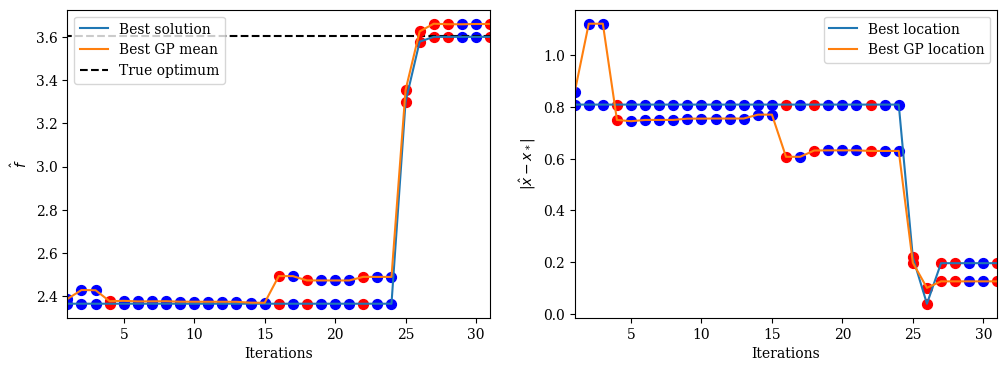

In [363]:
mfUCB.plot_results()

In [364]:
mfUCB.n_hf_evals

8

In [365]:
mfUCB.n_lf_evals

22

In [198]:
# Enzyme Toy Models
def toyModel(t,x, k):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    k1,k2,k3 = k
    dS0  = -k1*x[0]*x[3] + k2*x[1]
    dES0 =  k1*x[0]*x[3] - k2*x[1] - k3*x[1]
    dS1  =  k3*x[1] 
    dE   = -k1*x[3]*x[0] + k2*x[1] + k3*x[1] 
    return [dS0, dES0, dS1, dE]


def reducedToyModel(t,x, k):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    k1,k2,k3, E0 = k
    ke = (k1*k3)/(k2+ k3)
    dS0  = -ke*x[0]*E0
    dS1  = ke*x[0]*E0
    return [dS0, dS1]


def high_fidelity_toy(E):
    S0 = 5.0
    C0 = np.array([S0, 0.0, 0.0, E]) # initial concentrations of S0, ES0, ES1, S1, S2, E
    kvals = np.array([10, 50, 2])
    
    sol1 = solve_ivp(lambda t, x: toyModel(t, x, kvals), 
                         [0, 100], 
                         C0,
                         # t_eval=time_points, 
                         atol=np.sqrt(np.finfo(float).eps), 
                         rtol=np.sqrt(np.finfo(float).eps))
    return abs(10 - sol1.t[np.argmin(abs(sol1.y[2,:] - 0.67*S0))])


def low_fidelity_toy(E):
    S0 = 5.0
    C0 = np.array([S0, 0.0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
    kvals = np.array([10, 50, 2, E])
    sol2 = solve_ivp(lambda t, x: reducedToyModel(t, x, kvals), 
                         [0, 100], 
                         C0[:2],
                         # t_eval=time_points, 
                         atol=np.sqrt(np.finfo(float).eps), 
                         rtol=np.sqrt(np.finfo(float).eps))
    return abs(10 - sol2.t[np.argmin(abs(sol2.y[1,:] - 0.67*S0))])

def lf(x):
    if (type(x)) == np.ndarray:
        lf_vals = np.array([low_fidelity_toy(i) for i in x.ravel()]).reshape(-1,1)
    else:
        print(type(x))
        lf_vals = low_fidelity_toy(x)
    return -lf_vals
def hf(x):
    if (type(x)) == np.ndarray:
        hf_vals = np.array([high_fidelity_toy(i) for i in x.ravel()]).reshape(-1,1)
    else:
        hf_vals = high_fidelity_toy(x)
    return -hf_vals

In [200]:
mfUCB = multifidelityUCB(lf, hf, ndim=1, negate=True)
mfUCB.set_initial_data(12, 3, np.array([0, 1]))
mfUCB.set_model(ker='mat')
#mfgp.plot_model()
mfUCB.set_acquisition(5, 15)
mfUCB.init_bayes_loop()
mfUCB.true_model()

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale


mat


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.lengthscale


mat


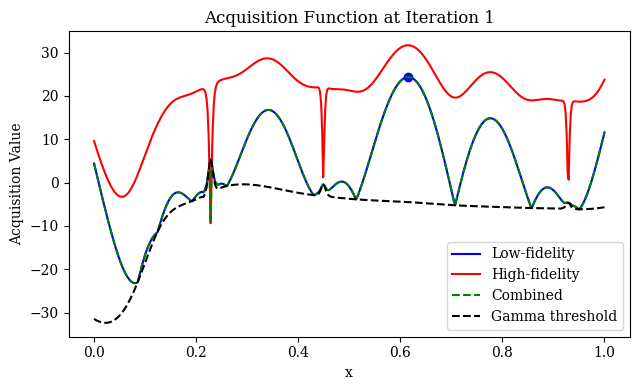

<class 'numpy.float64'>


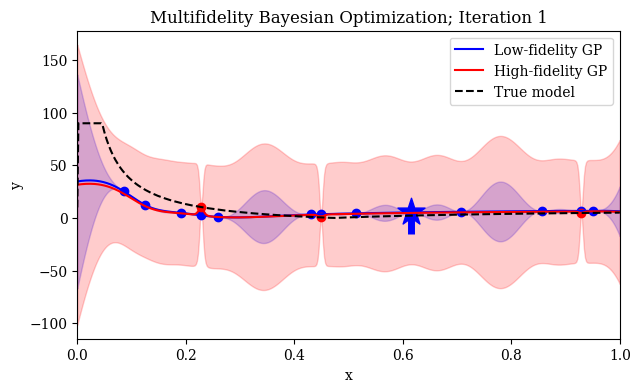

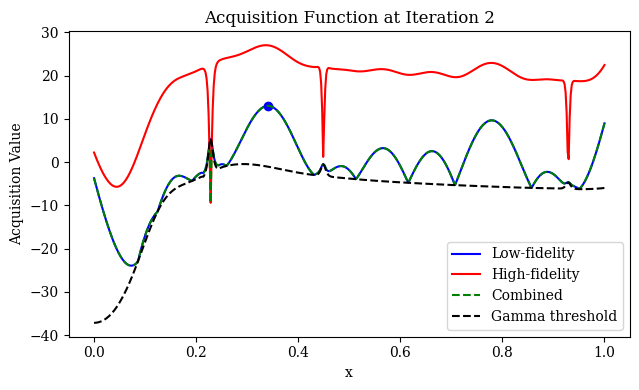

<class 'numpy.float64'>


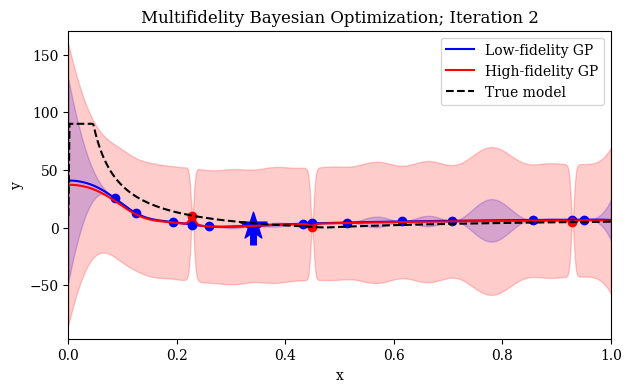

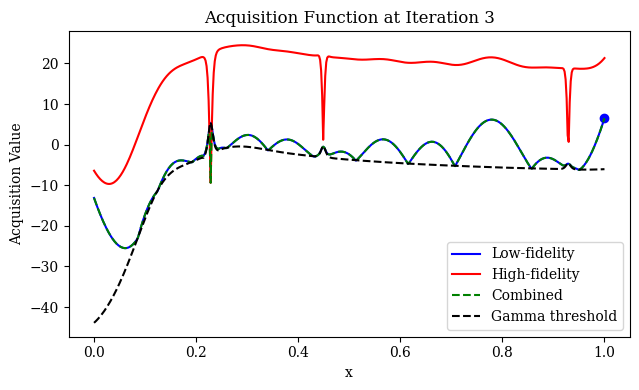

<class 'numpy.float64'>


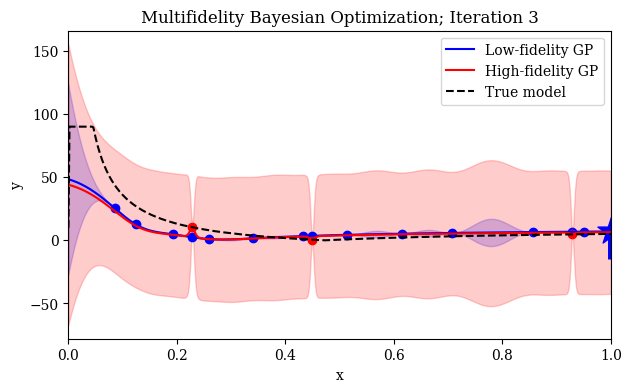

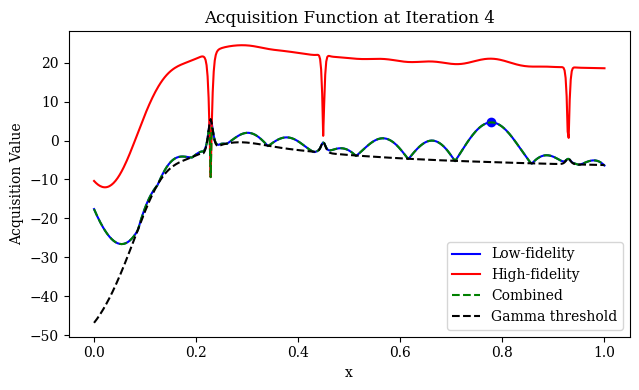

<class 'numpy.float64'>


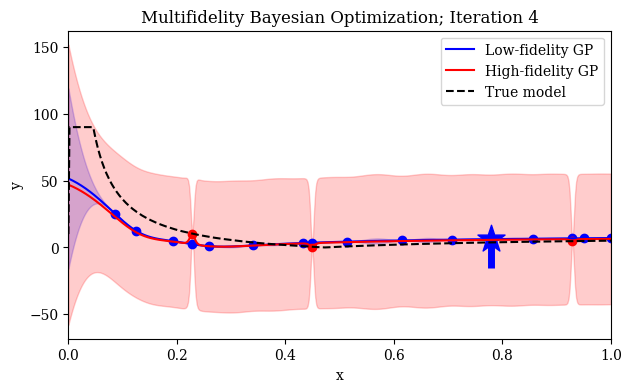

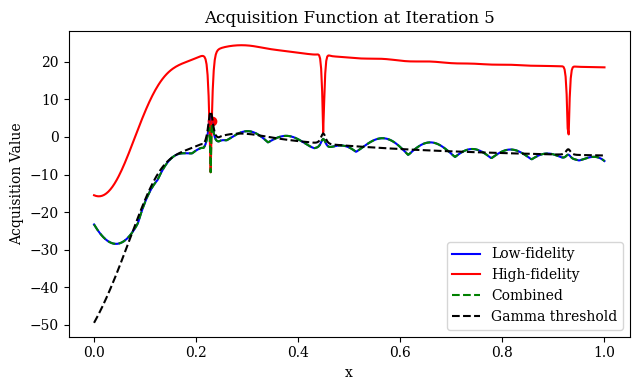

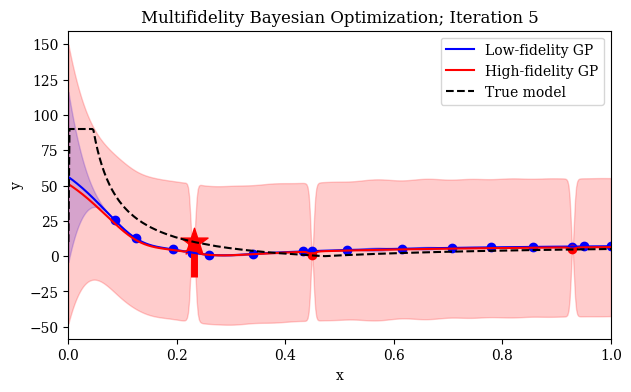

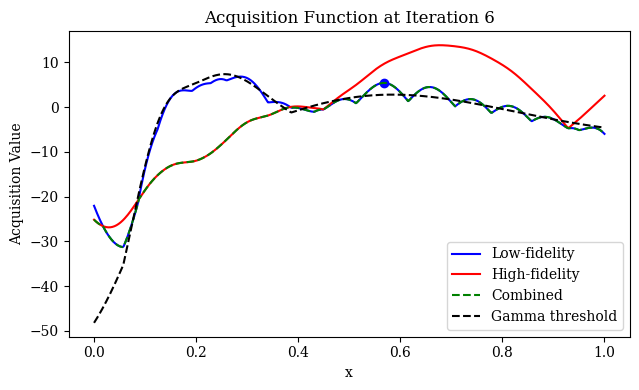

<class 'numpy.float64'>


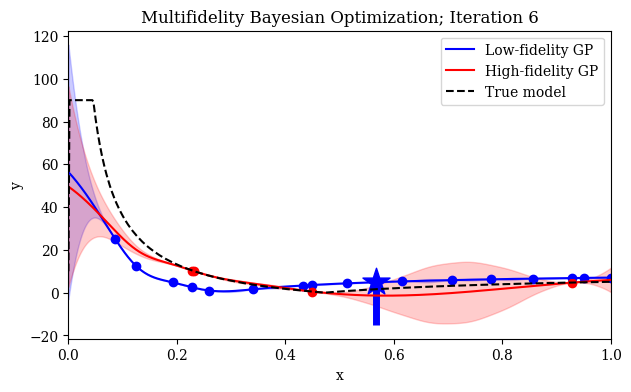

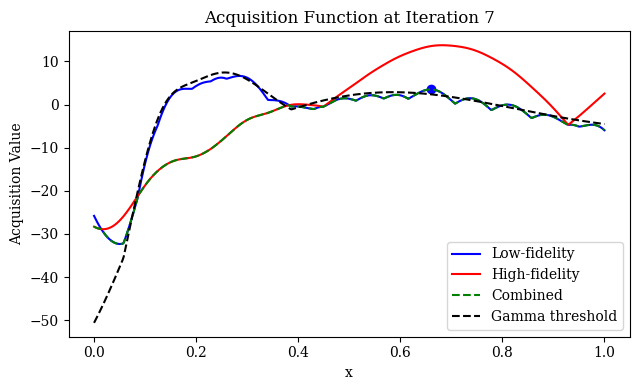

<class 'numpy.float64'>


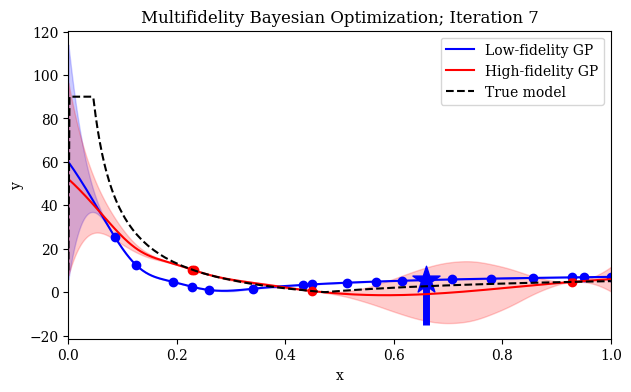

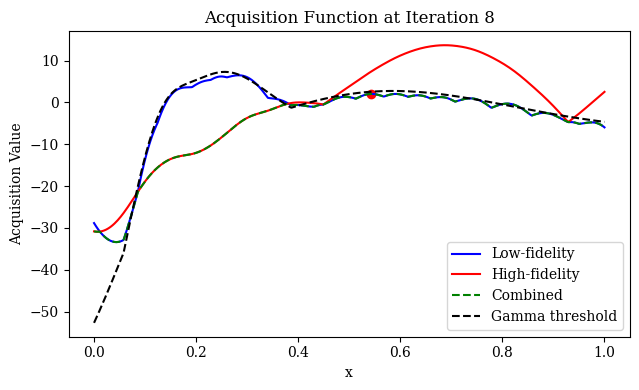

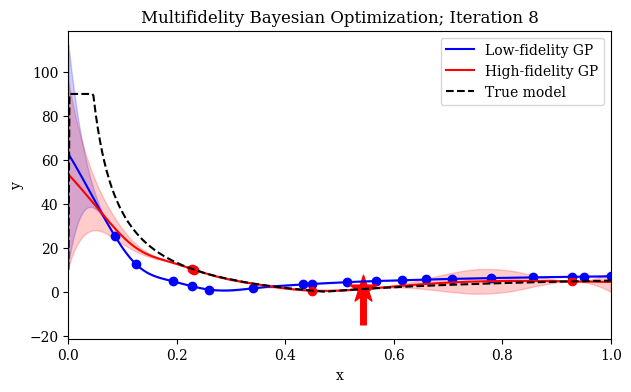

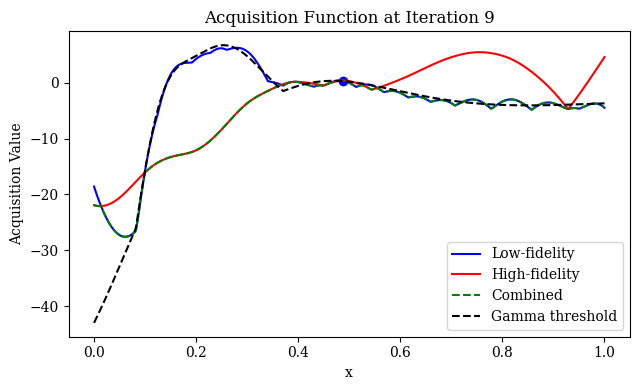

<class 'numpy.float64'>


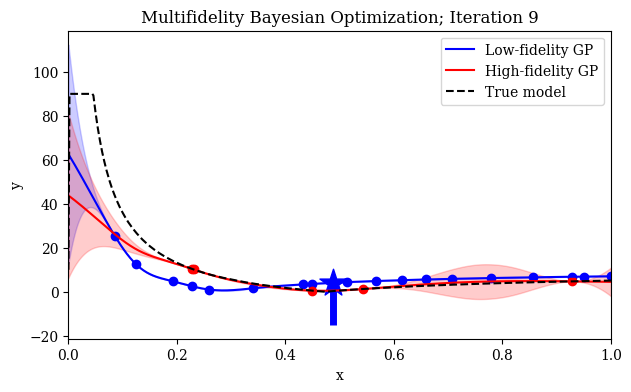

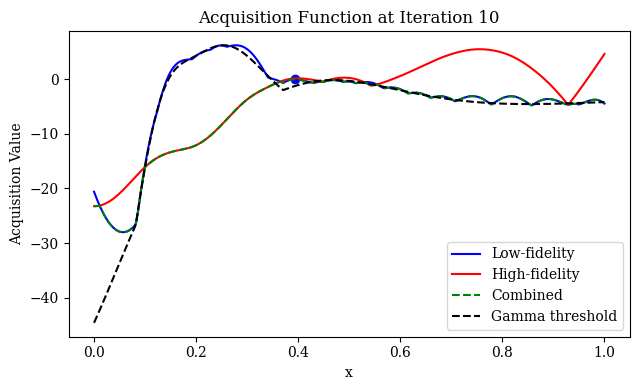

<class 'numpy.float64'>


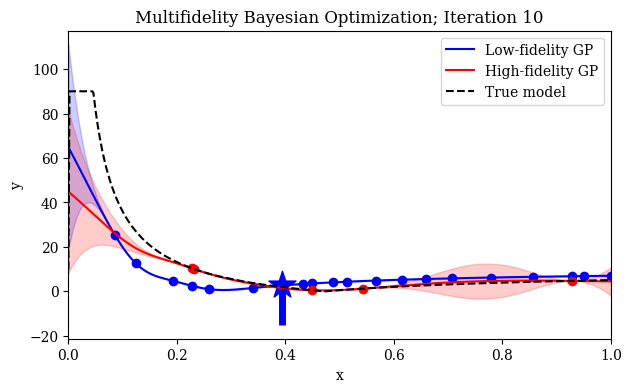

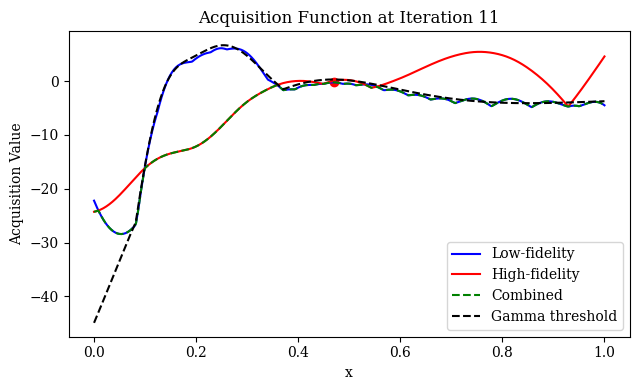

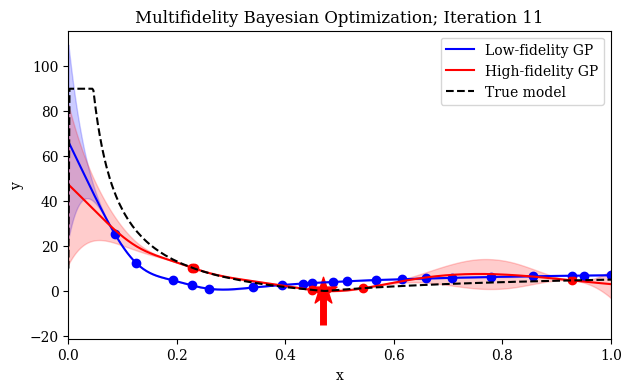

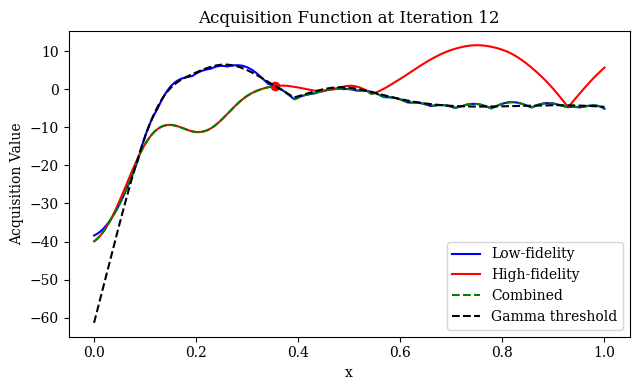

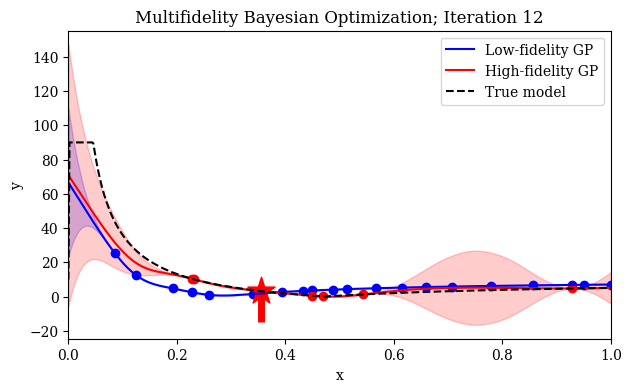

In [201]:
mfUCB.set_initial_data(12, 3, np.array([0, 1]))
mfUCB.set_model(ker='mat')
mfUCB.set_acquisition(5, 1/20)
mfUCB.init_bayes_loop()
x,f = mfUCB.run_bayes_loop(12)

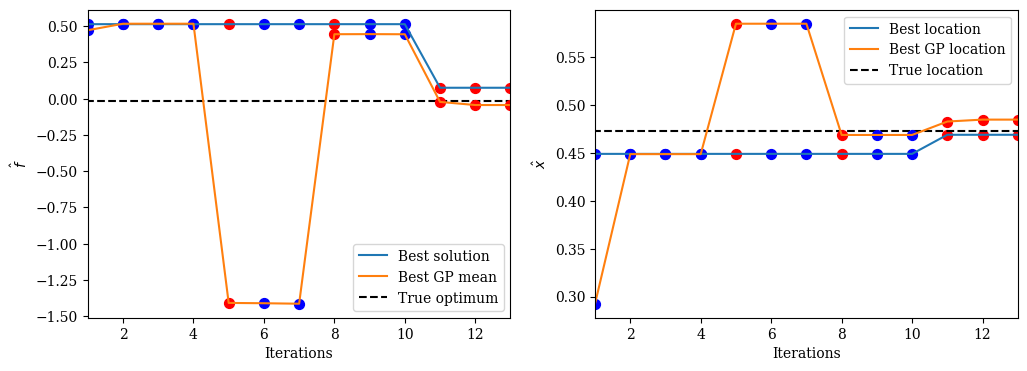

In [202]:
mfUCB.plot_results()

In [203]:
mfUCB.negate

True

In [204]:
mfUCB.n_hf_evals

4

In [205]:
mfUCB.n_lf_evals

8

In [184]:
x

ObsAr([0.46912243])

In [180]:
f

0.07570876862498999

In [263]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

In [261]:
mfUCB.model.X[:, 0]

ObsAr([0.92899722, 0.44916575, 0.22831532, 0.70714404, 0.19195997,
       0.92899722, 0.        , 0.0844831 , 0.61190075, 0.5222512 ,
       0.35466147, 0.4340014 , 0.2277189 , 0.14709189, 0.77025852,
       0.75534102, 0.75755648, 0.75728835, 0.75649093, 0.75737899,
       0.75737857])

In [265]:
# Normalize outputs
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(mfUCB.model.Y).ravel()

In [267]:
y_scaled

array([-1.82028375,  0.33513615,  0.93803558,  0.36000065,  1.05962948,
       -3.09467558,  1.07085803, -0.79185429,  0.08103247,  0.10949902,
        0.60523937, -0.94883289, -0.7831168 , -0.64581786,  0.48532182,
        0.5062839 ,  0.50671455,  0.50672593,  0.50665611,  0.50672405,
        0.50672407])

In [269]:
mfUCB.model.Y

ObsAr([[-4.14993704],
       [ 5.27077063],
       [ 7.90586705],
       [ 5.37944606],
       [ 8.43731829],
       [-9.71992963],
       [ 8.48639501],
       [ 0.34502626],
       [ 4.16015805],
       [ 4.284577  ],
       [ 6.45131252],
       [-0.34108113],
       [ 0.38321526],
       [ 0.98330861],
       [ 5.9271881 ],
       [ 6.01880721],
       [ 6.02068945],
       [ 6.02073922],
       [ 6.02043404],
       [ 6.020731  ],
       [ 6.02073105]])

In [273]:
import emukit

In [275]:
opt = emukit.core.optimization.optimizer.OptLbfgs(np.array([mfUCB.bounds]))
x = np.random.rand(5,mfUCB.ndim)
def acq_opt(x):
    x = np.array([np.hstack([x,1])])
    return -mfUCB.acquisition.evaluate(x)
optlist=[]
minlist = []
for i in x:
    loc, min = opt.optimize(i, acq_opt)
    optlist.append(loc)
    minlist.append(min)

In [959]:
optlist[np.argmin(minlist)]

array([[0.]])

30.22255524146263


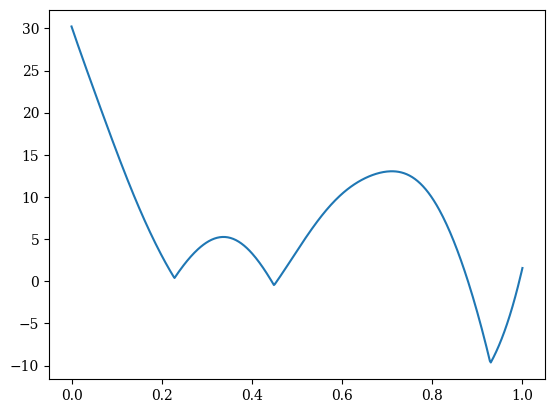

In [132]:
plt.plot(mfUCB.x_plot,mfUCB.acquisition.evaluate(mfUCB.x_plot_high))

In [621]:
import emukit.test_functions.forrester

# The multi-fidelity Forrester function is already wrapped as an Emukit UserFunction object in 
# the test_functions package
forrester_fcn, _ = emukit.test_functions.forrester.multi_fidelity_forrester_function()
forrester_fcn_low = forrester_fcn.f[0]
forrester_fcn_high = forrester_fcn.f[1]

np.random.seed(12346)
n_fidelities = 2

parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(n_fidelities)])

# Create initial dataset
x_low = np.random.rand(12)[:, None]
x_high = x_low[:3, :]

n_init = len(x_low)+len(x_high)

y_low = forrester_fcn_low(x_low)
y_high = forrester_fcn_high(x_high)

# Create autoregressive hierarchial GP model

x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])

x_plot = np.linspace(0, 1, 500)[:, None]
x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)

kern_low = GPy.kern.RBF(1)
kern_low.lengthscale.constrain_bounded(0.01, 0.5)

kern_err = GPy.kern.RBF(1)
kern_err.lengthscale.constrain_bounded(0.01, 0.5)

multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)

gpy_model.likelihood.Gaussian_noise.fix(0.1)
gpy_model.likelihood.Gaussian_noise_1.fix(0)

model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
model.optimize()

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


In [623]:
acquisition = CustomMultiFidelityAcquisition(model, parameter_space, 10)

In [625]:
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization.multi_source_acquisition_optimizer import MultiSourceAcquisitionOptimizer
from emukit.core.optimization import GradientAcquisitionOptimizer

initial_loop_state = create_loop_state(x_array, y_array)
acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(parameter_space), parameter_space)
candidate_point_calculator = SequentialPointCalculator(acquisition, acquisition_optimizer)
model_updater = FixedIntervalUpdater(model)
loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

In [661]:
xnext = candidate_point_calculator.compute_next_points(model)[:, :-1]

In [683]:
xnew = np.hstack([xnext[0], fidelity])

In [685]:
np.vstack([model.Y, forrester_fcn.f[fidelity](xnext)])
np.vstack([model.X, xnew])

array([[0.92899722, 0.        ],
       [0.44916575, 0.        ],
       [0.22831532, 0.        ],
       [0.70714404, 0.        ],
       [0.19195997, 0.        ],
       [0.85719177, 0.        ],
       [0.51332158, 0.        ],
       [0.0857998 , 0.        ],
       [0.25959895, 0.        ],
       [0.431627  , 0.        ],
       [0.95031458, 0.        ],
       [0.12427324, 0.        ],
       [0.92899722, 1.        ],
       [0.44916575, 1.        ],
       [0.22831532, 1.        ],
       [1.        , 0.        ]])

In [647]:
fidelity

0

In [754]:
def plot_optimization(loop, loop_state):
    colours = ['b', 'r']
    is_high_fidelity = loop.loop_state.X[:, -1] == 1
    x_low=loop.loop_state.X[~is_high_fidelity, :-1]
    y_low=loop.loop_state.Y[~is_high_fidelity]
    x_high=loop.loop_state.X[is_high_fidelity, :-1]
    y_high=loop.loop_state.Y[is_high_fidelity]

    mean_low, var_low = model.predict(x_plot_low)
    mean_high, var_high = model.predict(x_plot_high)

    plt.figure(figsize=(8,6))
    plt.contourf(X1, X2, mean_high.reshape(X1.shape), levels=50, cmap='viridis')
    plt.scatter(x_low[:, 0], x_low[:, 1], color='b')
    plt.scatter(x_high[:, 0], x_high[:, 1], color='r')

    xnew = loop_state.X[[-1], :]
    fidelity_idx = int(xnew[0, -1])
    ynew = currin.f[fidelity_idx](xnew[0,:-1])
    plt.scatter(xnew[:, 0], 
                xnew[:, 1], 
                color=colours[fidelity_idx], marker='*', s=420)
    plt.title('Low and High Fidelity Models')
    plt.xlabel('x1')
    plt.ylabel('x2');
    plt.show()

loop.iteration_end_event.append(plot_optimization)

In [756]:
is_high_fidelity = loop.loop_state.X[:, -1] == 1
x_low=loop.loop_state.X[~is_high_fidelity, :-1]
y_low=loop.loop_state.Y[~is_high_fidelity]
x_high=loop.loop_state.X[is_high_fidelity, :-1]
y_high=loop.loop_state.Y[is_high_fidelity]

In [758]:
xnew = loop.loop_state.X[[-1], :]
xnew[:, 0]

array([0.19195997])

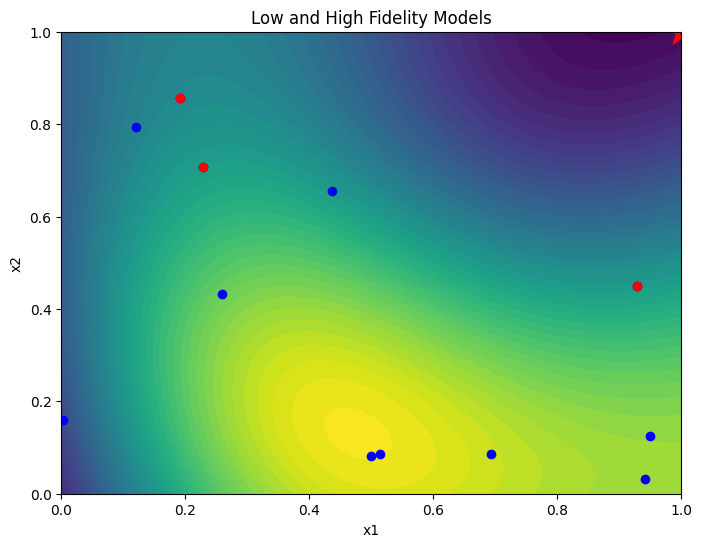

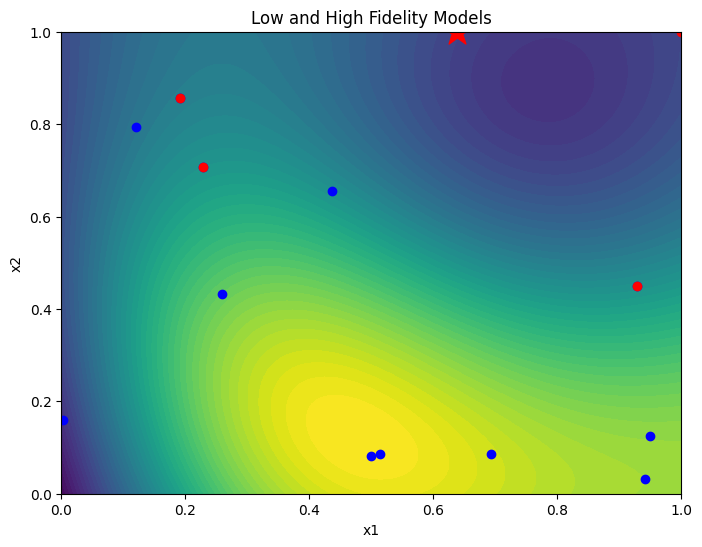

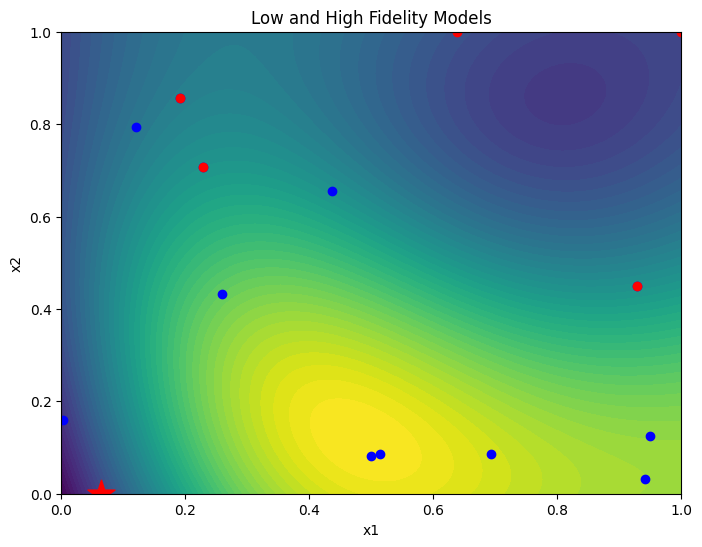

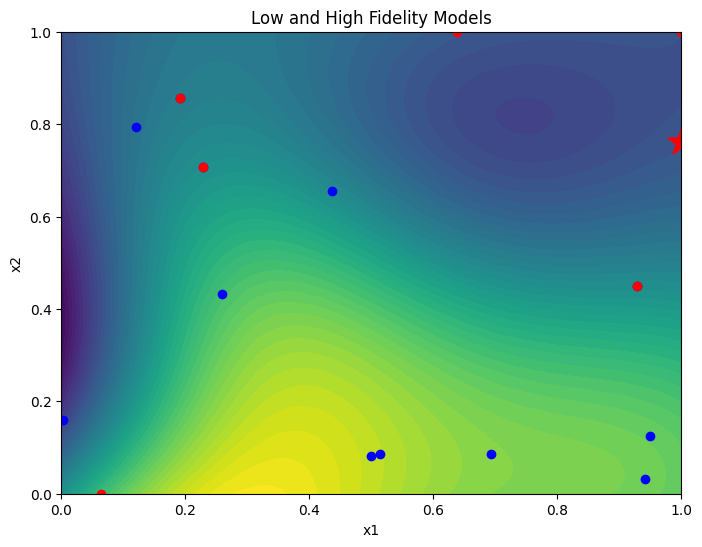

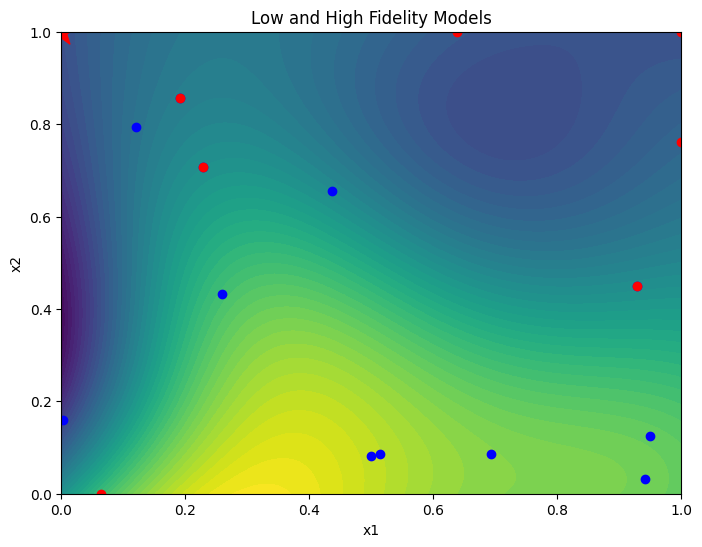

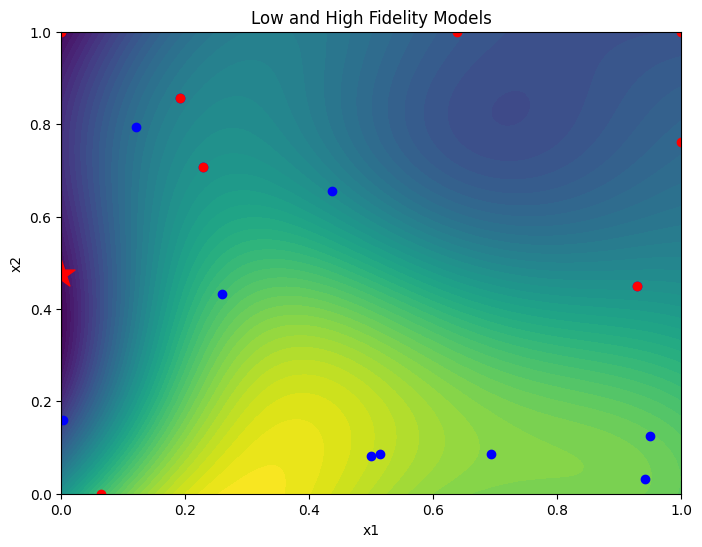

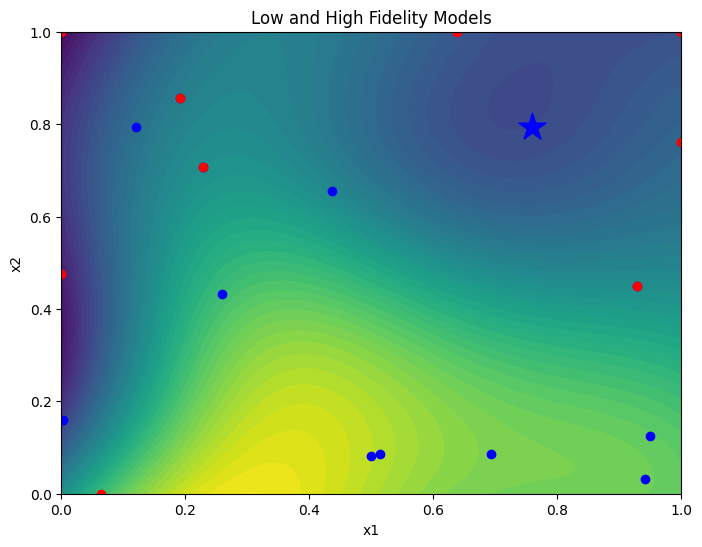

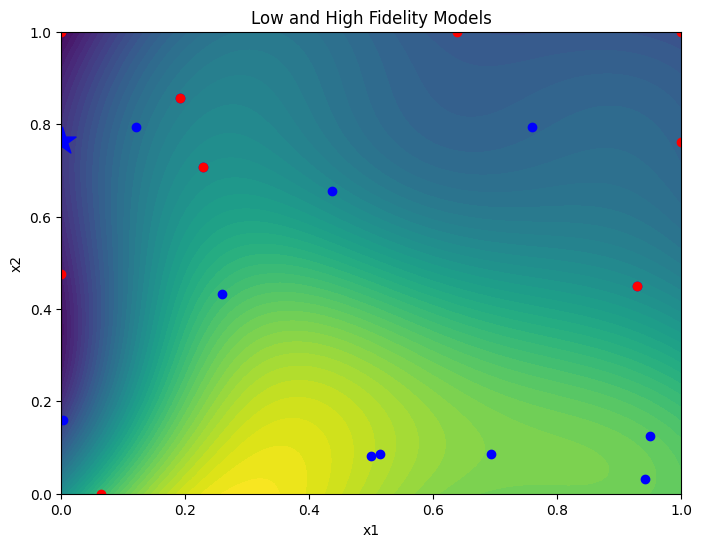

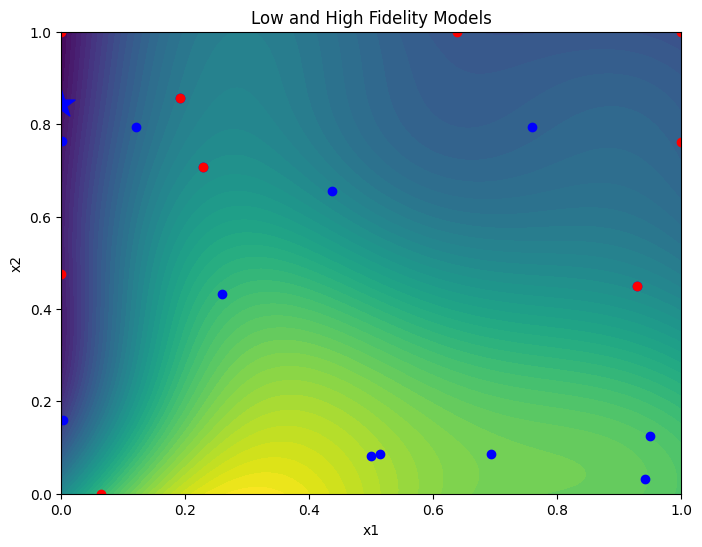

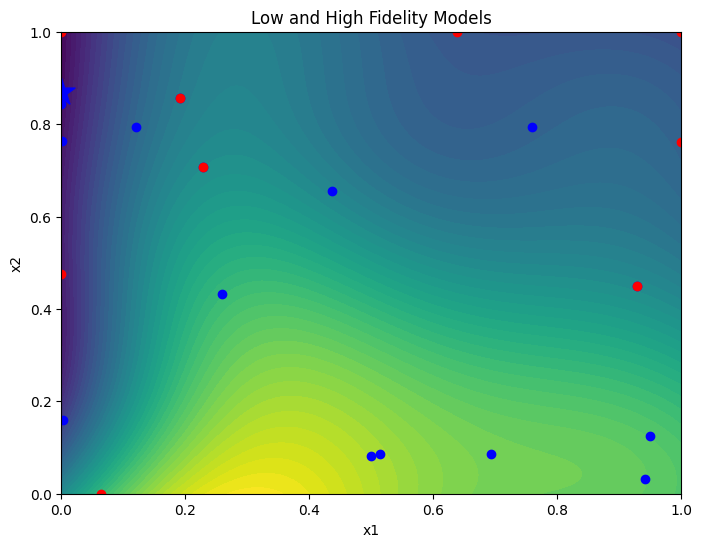

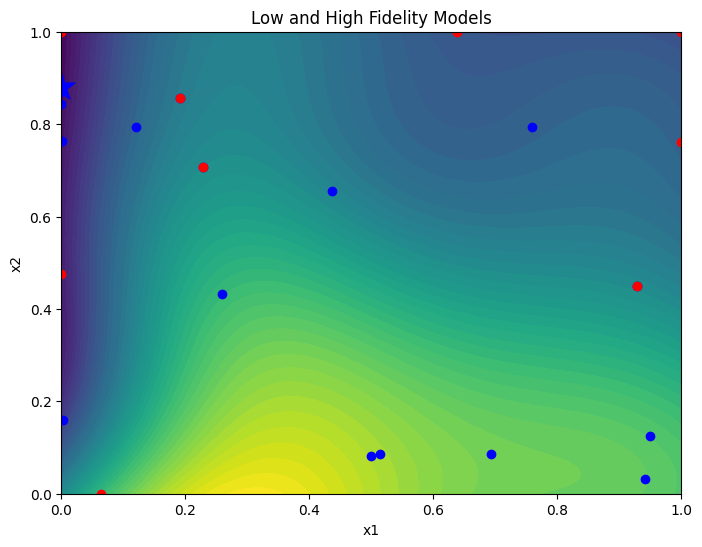

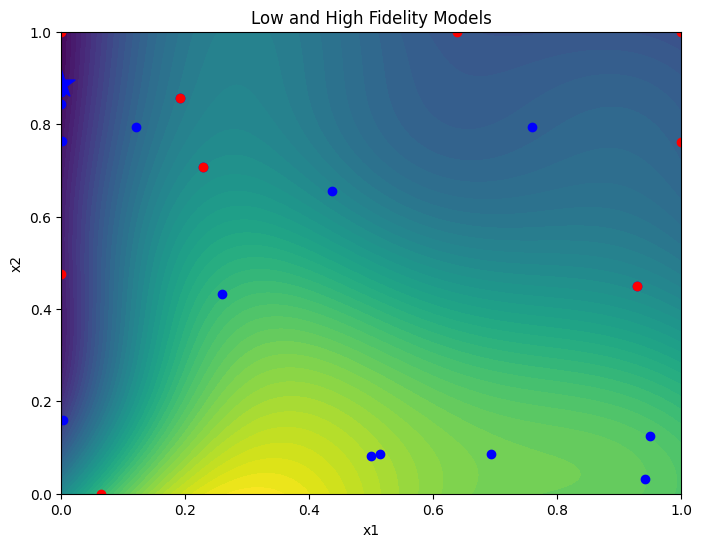

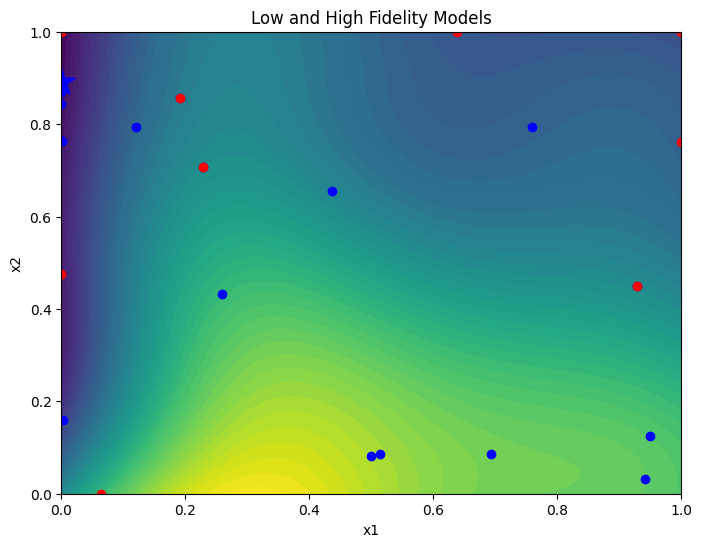

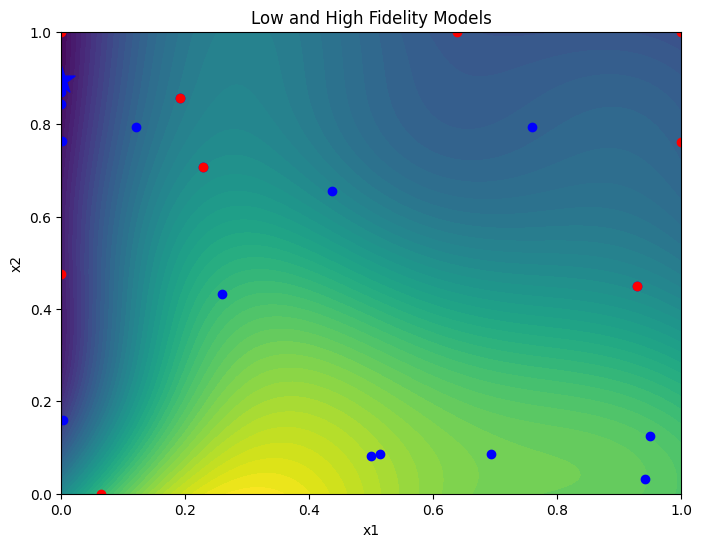

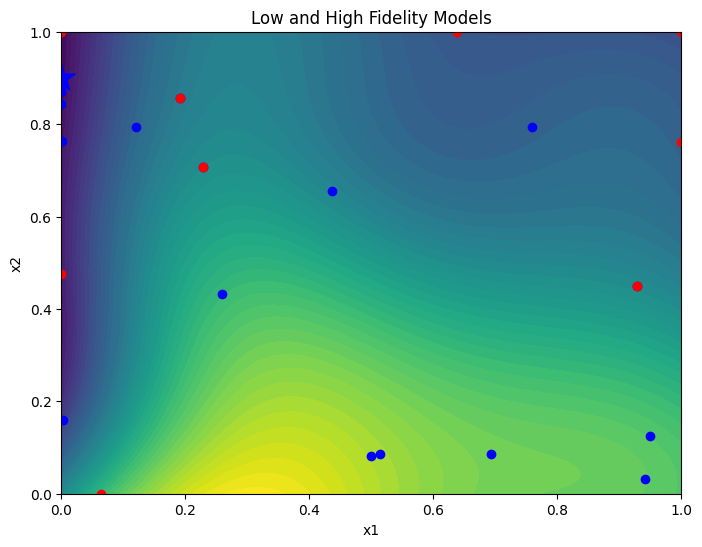

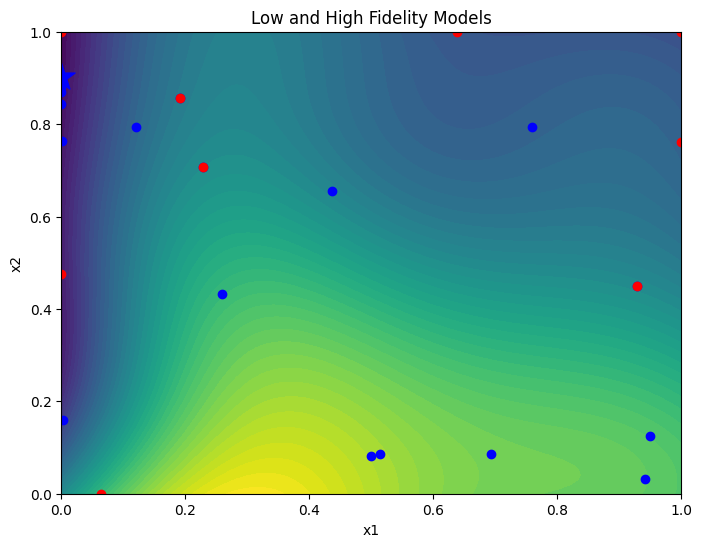

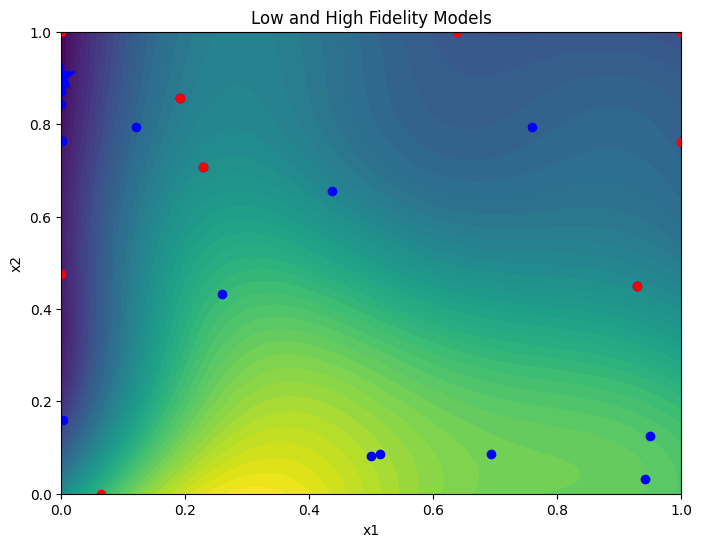

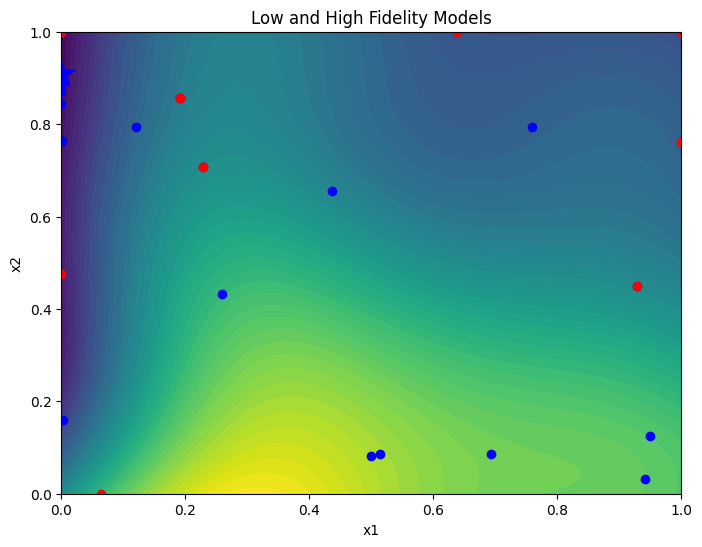

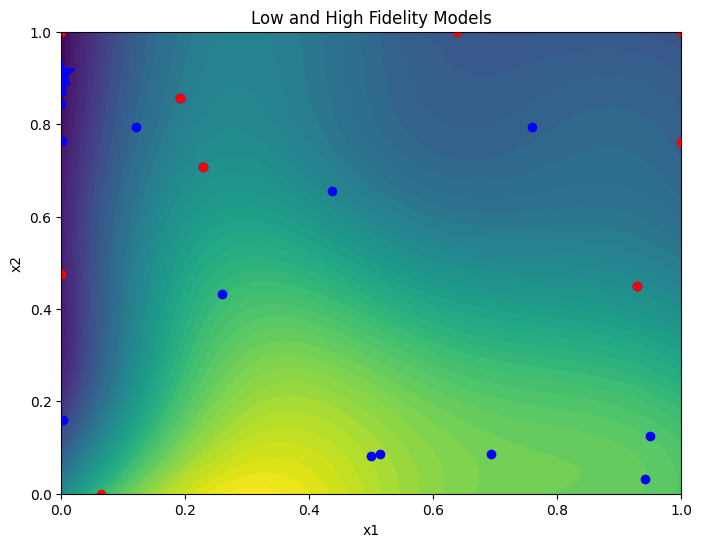

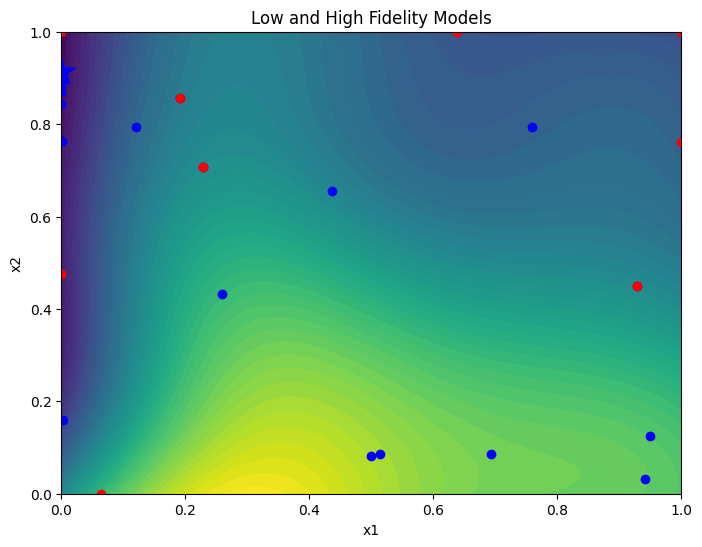

In [760]:
loop.run_loop(currin, 20)

In [574]:
candidate_point_calculator.compute_next_points(model)

array([[0.63766027, 1.        , 1.        ]])

In [582]:
currin_l(candidate_point_calculator.compute_next_points(model)[:, :-1]).shape

(1,)

In [332]:
currin_l(loop.candidate_point_calculator.compute_next_points(loop.loop_state).ravel()[:-1])

array([4.01374299])

In [449]:
loop.candidate_point_calculator.compute_next_points(loop.loop_state)[:, :-1]

array([[1., 1.]])

In [552]:
loop.candidate_point_calculator.compute_next_points(loop.loop_state)

array([[1., 1., 1.]])

In [562]:
YY = np.concatenate([loop.loop_state.Y, currin_l(loop.candidate_point_calculator.compute_next_points(loop.loop_state).ravel()[:-1]).reshape(-1,1)])
XX = np.concatenate([loop.loop_state.X, loop.candidate_point_calculator.compute_next_points(loop.loop_state)])

In [564]:
XX

array([[0.92899722, 0.44916575, 0.        ],
       [0.22831532, 0.70714404, 0.        ],
       [0.19195997, 0.85719177, 0.        ],
       [0.51332158, 0.0857998 , 0.        ],
       [0.25959895, 0.431627  , 0.        ],
       [0.95031458, 0.12427324, 0.        ],
       [0.94177041, 0.03279479, 0.        ],
       [0.12023077, 0.79321705, 0.        ],
       [0.50022656, 0.08240088, 0.        ],
       [0.69241064, 0.08590672, 0.        ],
       [0.00291934, 0.16050773, 0.        ],
       [0.43634521, 0.65420707, 0.        ],
       [0.92899722, 0.44916575, 1.        ],
       [0.22831532, 0.70714404, 1.        ],
       [0.19195997, 0.85719177, 1.        ],
       [1.        , 1.        , 1.        ]])

In [566]:
YY

array([[ 6.90792562],
       [ 6.89808402],
       [ 5.91858327],
       [11.50552877],
       [ 9.31483486],
       [ 9.93601598],
       [10.22971838],
       [ 5.40168619],
       [11.60375028],
       [10.6451194 ],
       [ 3.0832412 ],
       [ 6.53660271],
       [ 6.88188031],
       [ 6.98848095],
       [ 6.06838174],
       [ 4.01374299]])

In [568]:
model.set_data(XX, YY)

In [570]:
model.optimize()

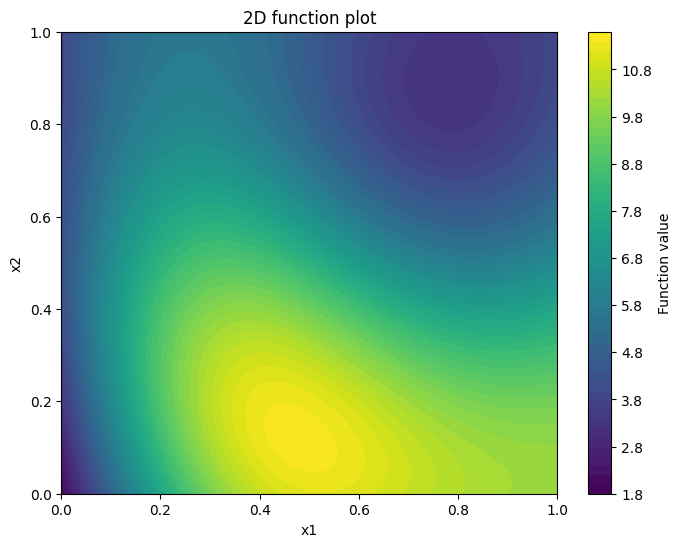

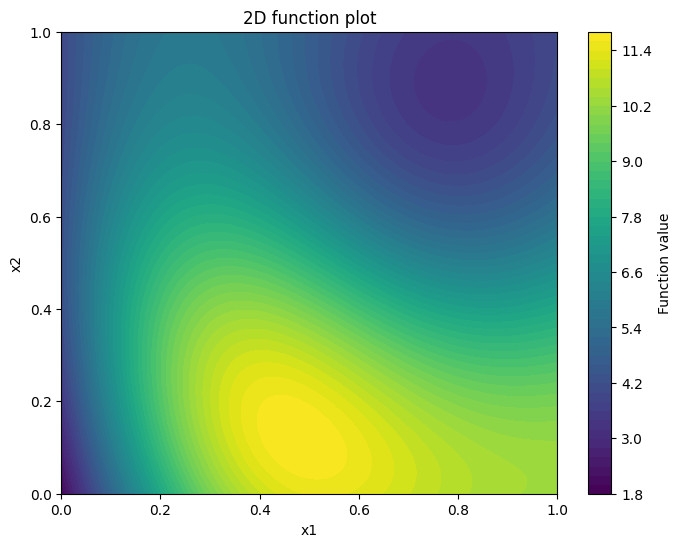

In [572]:
mean_low, var_low = model.predict(x_plot_low)
mean_high, var_high = model.predict(x_plot_high)


plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, mean_low.reshape(X1.shape), levels=50, cmap='viridis')
plt.colorbar(label="Function value")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2D function plot')
plt.show()

plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, mean_high.reshape(X1.shape), levels=50, cmap='viridis')
plt.colorbar(label="Function value")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2D function plot')
plt.show()

In [251]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

# Example data (inputs and outputs)
X = np.array([[1], [2], [3], [4], [5]])  # Inputs
y = np.array([3, 2, 0, 1, 5])            # Outputs

# Step 1: Normalize the inputs and outputs
# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize outputs
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Step 2: Define the Gaussian Process with an appropriate kernel
# You can choose an RBF kernel as an example
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Step 3: Fit the Gaussian Process model
gp.fit(X_scaled, y_scaled)

# Step 4: Make predictions (inverse transform the predictions if necessary)
X_test = np.array([[1.5], [3.5]])
X_test_scaled = scaler_X.transform(X_test)

# Predict scaled outputs
y_pred_scaled, sigma = gp.predict(X_test_scaled, return_std=True)

# Inverse transform the scaled predictions to get the original output scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Output the results
print(f"Predicted values: {y_pred}")
print(f"Standard deviation (sigma): {sigma}")

Predicted values: [2.2 2.2]
Standard deviation (sigma): [1. 1.]
